## Convergence of finite difference formulation of high order convected scheme

### Motivation for this notebook: previous observations

Using finite difference (FD) schemes to calculate the required derivatives to correct CS to a given LTE, the following has been noted with regard to convergence analysis of CS applied to the advection equation:

$$\frac{\partial f}{\partial t} + v\frac{\partial f}{\partial x} = 0, \qquad x\in [0,L], t\in [0,T], \qquad f(t, x + L) = f(t, x)$$

The following observations have been noted for a compact-support density function $f$:

<ol>
<li> If the non-zero density remains far from edges throughout simulation: CS convergence up to order 15
<ul>
<li> in attempting to correct to higher order, the error remains roughly within machine precision
</ul>
<li> If the non-zero density is advected through boundaries, CS converges up to an LTE of order 10.
<ul>
<li> in attempting to correct to higher oder, the error <i>increases</i>
</ul>
</ol>

(We can adjust the constant $v$, as well as the domain $D$ and simulation time $T$ so that the density $f$ (sufficiently compact) can either remain far from the edges or advected through the edges according to the boundary conditions. Note that the FD derivatives do not use the boundary conditions, and sample only grid points within the domain, hence near the edges appropriate degrees of asymmetric sampling is involved as usual.)

### Goals of this notebook

To investigate the failure of correcting convected scheme (CS) in certain cases to orders higher than an $LTE[CS] = O(\Delta x^{10})$ using finite difference estimates for the derivatives. Since the corrections hinge on accurate estimations of these derivatives, and this problem only happens in cases when the compact density is near the edges, it is thought the problem is with the FD formulations in the vicinity of the edges of the domain, which are necessarily a family of schemes which deviate from central differencing. Hence, the <b>goal</b> of this notebook is <b>to prove that varying degrees of asymmetric sampling in the FD derivatives are unable to achieve the LTE on the derivatives (required to correct CS up to the desired order.</b> We will reproduce the problem here, show that it is not a problem for non-edge cases, and compare convergent zones for the involved derivatives in edge and non-edge cases. The edge cases should show one more derivatives unable to achieve its required LTE.

## Review of high order convected scheme (CS) [brief]

In order to correct the numerical solution $f_{CS}(t^{n+1},x_i) = f_{i,CS}^{n+1} \equiv f_i^{n+1}$ at a given time step (cf. prelim document), we require adding contributions from all such high order preffluxes $[Uf]_{i'}^{n}$ transmitted from prepoints $\{i'\}$ that reach within a cell distance $\Delta x$ of a point $i$ (pre-efflux -> 'preffluxes' (/preˈfləks/) so that a portion of the density packet is appropriated to the cell center $i$. Following this prescription produces the approximate CS solution: at a time $t^{n+1}$

$$f_{exact}(t^{n+1},x_i) = f_i^{n+1} + O(\Delta x^{N+1})$$

where the local truncation error (LTE) is $O(\Delta x^{N+1})$, and corresponding global error (GE) at the end of simulation as $O(\Delta x^N)$. If convected scheme is employed in its raw form, its local truncation error is $O(\Delta x^2)$ which is attributable to its remap assignment at the start/end of each time step. A means of achieving higher order of local truncation error is to optimize the remap assignment. This is obtained by considering the CS update statement at a position $i$ at the time $t^{n+1}$ as contributions from all such locations that are convected from prepoint cells ($\{k\}$ or $\{i'\}$ equipped with velocities $\{v_k\}$ and $\{v_{i'}\}$) to within a cell spacing of the center $i$ (fractions of the density packets are allocated to all contiguous cells from its exact postpoint location). There is no error in pushing density packets an integral number of cells, hence the only source of error in convected scheme that can be corrected to higher order comes from the remap assignment involving the fractional CFL number $\alpha = \text{CFL} - \text{frac}[v\Delta t / \Delta x]$. A "corrected" $\alpha$ fraction we term $U$ defined such that $U = \alpha + O(\Delta x^{N+1})$ and whose explicit form can be determined. For the asserted uniform density profile for each density packet, we have the general total update statement where the integer push from the $\text{CFL}$ number pushes prepoints $\{k, i'\}$ to within one cell spacing of the grid point $i$ (either to $i$ or to $i \pm 1$), and the remaining push of the packet by the signed fraction $\alpha$ (or $U$) determines the weight of the packet to be allocated to each cell. Note, since the fraction $\alpha$ is the fractional cell width that remains for the density packet to be convected after it has already been pushed by its integral number (can be zero), any correction to $\alpha$ (i.e. $U$) needs to also be a fraction. In other words, the fraction $U$ cannot be permitted to "overcorrected" such that it exceeds unity, else it violates the physical situation by pushing the packet outside of the destination cells (hence, it's value needs to be restrained, described later).

In high order CS, 

$$f_i^{n+1} = \pm \sum_{k: k\to i\mp1}U_{k}^n f_{k}^n + \sum_{i' : i'\to i} (1 \mp U_{i'}^n) f_{i'}^n$$

where $U_{\ell},\, (\ell = i', k)$ labels the originating grid point's fractional CFL number (in classical CS, we swap $U$ with $\alpha$). If $v > 0\, (U > 0)$, choosing the top sign produces the appropriate update statement, and vice versa. The above is an update statement for all cells with arbitrary velocities ($\partial_t f + v(t,x) \partial_x f = 0$). Alternatively, each cell can be viewed to solve its own 1D constant speed advection equation ($\partial_t f_{\ell} + v_{\ell}\partial_x f_{\ell} = 0$) where $f_{\ell}$ a density function for all $x$ with compact support that is only nonzero at the cell $x_{\ell} \pm \Delta x$, and thus the total solution is the assembly of each solution for each density packet $\ell$, i.e. 

$$\sum_{\ell} \partial_t f_{\ell} + v_{\ell}\partial_x f_{\ell} = 0 \rightarrow \partial_t f + v(t,x) \partial_x f = 0,$$ 

which follows from our partition $\sum_{\ell} f_{\ell} = f$. Thus, rather than viewing the update as a sum over all cells that are advected to contiguous cells of a cell center of interest $i$, we can consider one cell at a time for an incremental update and discern a relevant correction for the one-cell update which can be combined with corrected one-cell updates for all cells to assemble the total solution. Equivalently, we can always identify pairs of cells that map to contiguous cells (even if one maps zeros, so there is not conflict with an odd number of gridpoints). Choosing to pursue this option allows for some convenient cancellation of terms that are not transparent in the one-cell update statement so we elect to analyze one such pair $\{k,i'\}$ so that the above total statement collapses to the simple statement:

$$f_i^{n+1} = \pm U_{i \mp 1}^n f_{i \mp 1}^n + (1 \mp U_i^n) f_i^n$$

Where it is understood in the above update that only density advected to within one cell spacing $\Delta x$ of a grid point $i$ is involved in the above sum. Thus, correcting this update for one pair to higher order permits us to correct the total solution by summing over all pairs. To that end, we assert the density at $(t^n, x_i)$ is known exactly, i.e. $f_i^n = f_{exact}(t^n,x_i) \equiv f(t,x)$. Labeling this time and position without sub/superscripts to emphasize it is analytically exact, we expand the above to obtain:

$$f^{n+1}_{i} =  f(t,x) + \sum_{p = 1}^{N}\frac{(\mp\Delta x)^p}{p!}\frac{\partial^p(Uf)}{\partial x^p}\biggr|_{(t,x)} + \mathcal{O}(\Delta x^{N+1}) \qquad \qquad \text{(*)}$$

where again, choosing the top sign corresponds to $v > 0 \, (U > 0)$. The (normalized) flux $[Uf]$ is modelled as a power series with to be determined coefficient functions $\beta_q = \beta_q(\alpha )$ which after much algebra can be shown to be recorded as the following:

$$[Uf]_{i'}^n = \sum_{q = 0}^{N-1} c_q d^n_{i,q}$$

where,

$$c_q = (-1)^q\beta_q(\alpha )$$

$$d_{i,q}^n = (\Delta x)^q \frac{\partial^q f^n}{\partial x^q}$$

$$c_0d_{i,0}^0 = c_0 (\Delta x)^0 \frac{\partial^0 f^n}{\partial x^0} = c_0 f(t,x_i) = \alpha f(t,x_i)$$

so that,

$$[Uf]_{i'}^n \sim \sum_{q = 0}^{N-1}(\Delta x)^q \frac{\partial^q f^n}{\partial x^q}$$

Comparing the above formulation for the flux $[Uf]$ and eq. $\text{(*)}$, 

$$f^{n+1}_{i} \sim f(t,x) + \frac{(\mp\Delta x)^1}{1!}\frac{\partial^1}{\partial x^1}\left(f(t,x) + \sum_{q = 1}^{N-1}(\Delta x)^q \frac{\partial^q f^n}{\partial x^q} \right) + \frac{(\mp\Delta x)^2}{2!}\frac{\partial^2}{\partial x^2}\left(f(t,x) + \sum_{q = 1}^{N-1}(\Delta x)^q \frac{\partial^q f^n}{\partial x^q} \right)  + \ldots + \frac{(\mp\Delta x)^N}{N!}\frac{\partial^N}{\partial x^N}\left(f(t,x) + \sum_{q = 1}^{N-1}(\Delta x)^q \frac{\partial^q f^n}{\partial x^q} \right) + \mathcal{O}(\Delta x^{N+1})$$

it is clear that the minimum criteria that needs to be met so that the CS solution for the density $f$ is accurate with a local truncation error of $O(\Delta x^{N+1})$ is that this sum over $p$ and $q$ has each term to have an LTE of $O(\Delta x^{N+1})$. Since the outer sum over $p\in \mathbb{N}_1^N$ multiplies each series over $q$ (the flux expansion $[Uf]$) by at least $p = 1$, $(\Delta x)^1$, this reduces the restriction on the accuracy by exactly one, so that each flux $[Uf]$ must have an LTE of $O(\Delta x^N)$, which is guaranteed then to be of order $O(\Delta x^{N+1})$ overall. 

Thus, we have the following requirements:

###High order prescription to achieve $LTE[CS] = O(\Delta x^{N+1})$

<ol>
<li> $N-1$ derivatives are needed, $\partial_x^{\ell} f$, where $\ell = 1, 2, \ldots, N-1$
<li>The LTE on each derivative decreases with increasing order $\ell$ according to: $$\text{LTE}[d_{i,\ell}^n]_{\ell\geq 1} = \text{LTE}\left[ (\Delta x)^{\ell} \frac{\partial^{\ell} f^n}{\partial x^q} \right] = O(\Delta x^N) \Rightarrow \boxed{\text{LTE}\left[\frac{\partial^{\ell} f}{\partial x^{\ell}}\right] = O(\Delta x^{N - \ell})}$$
</ol>
The reader is invited to review the preliminary document at dsirajud/Preliminary-examination/ for more details.

### Setup

We examine test cases of 1D0V advection (i.e. 1D in configuration, and "0-dimensional" in velocity as the velocity is chosen and is not a phase space variable). That is, we solve

$$\frac{\partial f}{\partial t} + v\frac{\partial f}{\partial x} = 0, \quad \text{where } f = f(t,x)$$

$$x\in [-0.5, 1.5], t\in [0,1.0], \qquad \text{periodic BCs: }f(t, 1.5) = f(t,-0.5)$$

for the domain $x\in [-0.5, 1.5]$, $t\in [0, 1.0]$, and the velocity $v$ is to be chosen. The exact solution at any time $t$ is given by $f(t,x) = f(0, x - vt)$ for any sign of $v$.

For the convergence analysis of high order CS, we use an asymmetric, infinitely differentiable function for an initial condition that is the superposition of Gaussian bells:

$$f_0(x) = a\exp\left[-\left(\frac{x + x_a}{w_a}\right)^2\right] + b \exp\left[-\left(\frac{x + x_b}{w_b}\right)^2\right] + c\exp\left[-(\frac{x + x_c}{w_c})^2\right] + \ldots $$ 

or:

$$f_0(x) = \sum_{m = \{a,b,c, \ldots \}} m\exp\left[-\left(\frac{x + x_m}{w_m}\right)^2\right]$$ 

For the purposes of this noteboook, we investigate why CS cannot be corrected above an order $N = 9$ (i.e. $LTE[CS] = O(\Delta x^{N+1}) = O(\Delta x^{10})$. This relies on the accurate estimation of derivatives of the density function ($\partial_x^{dn} f$) $dn = 1, 2, 3, 4, 5, 6, 7, 8$ at the requisite LTE ($ = N - \ell, \, \ell\in\mathbb{N}_1^{N-1}$). The goal of this notebook is to verify or otherwise reject the posit that FD calculations are unable to produce accurate enough estimates of the derivatives above a certain threshold LTE order ($10$ for this density test case). 

we anticipate that the first 8 derivatives will have either very slight or no convergence problems in the ranges of mesh sizes considered for the case of $LTE[CS] = O(\Delta x^{10}$). For $LTE[CS] \geq O(\Delta x^{11})$, one or more of the derivatives should show significant problems in reaching the derivative's requisite LTE for enough mesh sizes to allow the correction of CS to hold.

Thus, for the purposes of this notebook, 10 derivatives will be needed at minimum (needed for $LTE[CS] = O(\Delta x^{11})$. The analytical representations of these derivatives are easily obtained, which we report several additional derivatives ($\partial_x^{dn} f$) that were used in the course of the study.


<u> $\underline{dn = 1}:$</u>
\begin{eqnarray*}
f^{(1)}_0(x) & = & \sum_{m} m\left(-\frac{2}{w_m^2}\right)(x + x_m)\exp\left[-\left(\frac{x + x_m}{w_m}\right)^2\right]
\end{eqnarray*}


<u> $\underline{dn = 2}:$</u>
\begin{eqnarray*}
f^{(2)}_0(x) & = & \sum_{m} m\left(-\frac{2}{w_m^2}\right)\left[1 + \left(-\frac{2}{w_m^2}\right)(x + x_m)^2\right]\exp\left[-\left(\frac{x + x_m}{w_m}\right)^2\right]
\end{eqnarray*}


<u> $\underline{dn = 3}:$</u>
\begin{eqnarray*}
f^{(3)}_0(x) & = & \sum_{m} m\left(-\frac{2}{w_m^2}\right)^2\left[3(x + x_m) + \left(-\frac{2}{w_m^2}\right)(x + x_m)^3\right]\exp\left[-\left(\frac{x + x_m}{w_m}\right)^2\right] 
\end{eqnarray*}


<u> $\underline{dn = 4}:$</u>

\begin{equation}
\begin{split}
f^{(4)}_0(x) = \sum_{m} m\left(-\frac{2}{w_m^2}\right)^2\left[3 + 6\left(-\frac{2}{w_m^2}\right)(x + x_m)^2 \right. \\
\left. + \left(-\frac{2}{w_m^2}\right)^2(x + x_m)^4\right]\exp\left[-\left(\frac{x + x_m}{w_m}\right)^2\right]
\end{split}
\end{equation}


<u> $\underline{dn = 5}:$</u>

\begin{equation}
\begin{split}
f^{(5)}_0(x)  =  \sum_{m} m\left(-\frac{2}{w_m^2}\right)^3\left[ 15(x + x_a) + 10\left(-\frac{2}{w_m^2}\right) (x + x_m)^3 \right. \\
\left. + \left(-\frac{2}{w_m^2}\right)^2 (x + x_m)^5\right]\exp\left[-\left(\frac{x + x_m}{w_m}\right)^2\right]
\end{split}
\end{equation}

<u> $\underline{dn = 6}:$</u>


\begin{equation}
\begin{split}
f^{(6)}_0(x)  =  \sum_{m} m\left(-\frac{2}{w_m^2}\right)^3\left[ 15 + 45 \left(-\frac{2}{w_m^2}\right) (x + x_m)^2 + 15\left(-\frac{2}{w_m^2}\right)^2 (x + x_m)^4 \right. \\
\left. + \left(-\frac{2}{w_m^2}\right)^3 (x + x_m)^6\right]\exp\left[-\left(\frac{x + x_m}{w_m}\right)^2\right]
\end{split}
\end{equation}

<u> $\underline{dn = 7}:$</u>
\begin{equation}
\begin{split}
f^{(7)}_0(x)  =  \sum_{m} m\left(-\frac{2}{w_m^2}\right)^4\left[ 105(x + x_m) + 105 \left(-\frac{2}{w_m^2}\right) (x + x_m)^3 \right. \\
\left. + 21\left(-\frac{2}{w_m^2}\right)^2 (x + x_m)^5 + \left(-\frac{2}{w_m^2}\right)^3 (x + x_m)^7\right]\exp\left[-\left(\frac{x + x_m}{w_m}\right)^2\right]
\end{split}
\end{equation}

<u> $\underline{dn = 8}:$</u>

\begin{equation}
\begin{split}
f^{(8)}_0(x)  =  \sum_{m} m\left(-\frac{2}{w_m^2}\right)^4\left[ 105 + 420 \left(-\frac{2}{w_m^2}\right) (x + x_m)^2 + 210\left(-\frac{2}{w_m^2}\right)^2 (x + x_m)^4 \right. \\
\left. + 28\left(-\frac{2}{w_m^2}\right)^3 (x + x_m)^6 + \left(-\frac{2}{w_m^2}\right)^4 (x + x_m)^8\right]\exp\left[-\left(\frac{x + x_m}{w_m}\right)^2\right]
\end{split}
\end{equation}

<u> $\underline{dn = 9}:$</u>

\begin{equation}
\begin{split}
f^{(9)}_0(x)  =  \sum_{m} m\left(-\frac{2}{w_m^2}\right)^5 \left[ 945(x + x_m) + 1260 \left(-\frac{2}{w_m^2}\right) (x + x_m)^3 + 378\left(-\frac{2}{w_m^2}\right)^2 (x + x_m)^5 \right. \\
\left. + 36\left(-\frac{2}{w_m^2}\right)^3 (x + x_m)^7 + \left(-\frac{2}{w_m^2}\right)^4 (x + x_m)^9\right]\exp\left[-\left(\frac{x + x_m}{w_m}\right)^2\right]
\end{split}
\end{equation}

<u> $\underline{dn = 10}:$</u>

\begin{equation}
\begin{split}
f^{(10)}_0(x)  =  \sum_{m} m\left(-\frac{2}{w_m^2}\right)^5 \left[ 945 + 4725 \left(-\frac{2}{w_m^2}\right) (x + x_m)^2 + 3150\left(-\frac{2}{w_m^2}\right)^2 (x + x_m)^4 \right. \\
\left. + 630\left(-\frac{2}{w_m^2}\right)^3 (x + x_m)^6 + 45 \left(-\frac{2}{w_m^2}\right)^4 (x + x_m)^8 +  \left(-\frac{2}{w_m^2}\right)^5 (x + x_m)^{10}\right]\exp\left[-\left(\frac{x + x_m}{w_m}\right)^2\right]
\end{split}
\end{equation}


<u> $\underline{dn = 11}:$</u>

\begin{equation}
\begin{split}
f^{(11)}_0(x)  =  \sum_{m} m\left(-\frac{2}{w_m^2}\right)^6 \left[ 10395(x + x_m) + 17325 \left(-\frac{2}{w_m^2}\right) (x + x_m)^3 + 6930\left(-\frac{2}{w_m^2}\right)^2 (x + x_m)^5 \right. \\
\left. + 990\left(-\frac{2}{w_m^2}\right)^3 (x + x_m)^7 + 55\left(-\frac{2}{w_m^2}\right)^4 (x + x_m)^9 + \left(-\frac{2}{w_m^2}\right)^5 (x + x_m)^{11}\right]\exp\left[-\left(\frac{x + x_m}{w_m}\right)^2\right]
\end{split}
\end{equation}

<u> $\underline{dn = 12}:$</u>

\begin{equation}
\begin{split}
f^{(12)}_0(x)  =  \sum_{m} m\left(-\frac{2}{w_m^2}\right)^6 \left[10395 + 62370 \left(-\frac{2}{w_m^2}\right) (x + x_m)^2 + 51975\left(-\frac{2}{w_m^2}\right)^2 (x + x_m)^4 \right. \\
\left. + 13860\left(-\frac{2}{w_m^2}\right)^3 (x + x_m)^6 + 1485\left(-\frac{2}{w_m^2}\right)^4 (x + x_m)^8 +  66\left(-\frac{2}{w_m^2}\right)^5 (x + x_m)^{10} + \left(-\frac{2}{w_m^2}\right)^6 (x + x_m)^{12}\right]\exp\left[-\left(\frac{x + x_m}{w_m}\right)^2\right]
\end{split}
\end{equation}




## Setup: "Non-edge" density vs. "edge" density

We choose a triple asymmetric Gaussian bell structure and give its functional form in positions far (shown just below) and far from the edge (subsequently). Far from the edge, its form takes:

$$f_0(x) = a\exp\left[-\left(\frac{x + x_a}{w_a}\right)^2\right] + b\exp\left[-\left(\frac{x + x_b}{w_b}\right)^2\right] + c\exp\left[-(\frac{x + x_c}{w_c})^2\right], \qquad \underline{\text{Non-edge density}}$$ 

$$\text{where we choose the widths and centroids: } a = 3/4, b = 1, c = 1/2, w_a = 0.03, w_b = 0.06, w_c = 0.1, x_a = 0.25, x_b = 0, x_c = -0.25$$

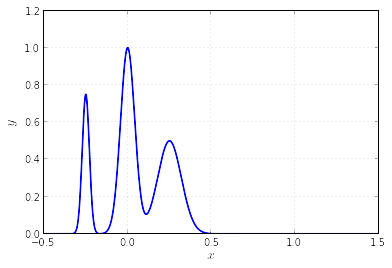

In [1]:
%matplotlib inline
%reload_ext autoreload 
%autoreload 2 
import numpy as np
import matplotlib.pyplot as plt


a, c = 3/4., 1/2.
w_a, w_b, w_c = 0.03, 0.06, 0.1
x_a, x_c = 0.25, -0.25

ax, bx = -0.5, 1.5
x = np.linspace(ax, bx,1000)
f = a * np.exp(-((x + x_a) / w_a) ** 2) + np.exp(-((x/w_b)**2)) + c*np.exp(-((x + x_c)/w_c) ** 2)
                                                 
plt.plot(x,f,'-b', linewidth = 2)
plt.grid()
plt.xlabel('$x$', fontsize = 14)
plt.ylabel('$y$', fontsize = 14)

The idea behind the construction of such a function for the test case is that it has sufficient variability on both longer and shorter wavelengths so that higher order solvers might be able to show visually (as well as by the numbers) that it produces more accurate as compared to lower order solvers of the same kind.

The "edge" version of the density has the following functional form, where we are recreating the situation in the CS convergence test cases (not shown here) that advect the density right-ward with a high enough velocity that it encounters the right-edge:

$$f(x) = a\exp\left[-\left(\frac{x + x_a}{w_a}\right)^2\right] + b\exp\left[-\left(\frac{x + x_b}{w_b}\right)^2\right] + c\exp\left[-\left(\frac{x + x_c}{w_c}\right)^2\right] + d\exp\left[-\left(\frac{x + x_d}{w_d}\right)^2\right], \qquad \underline{\text{Edge density}}$$ 

$$\text{where } a = 3/4, b = 1, c = d = 1/2; w_a = 0.03, w_b = 0.06, w_c = w_d = 0.1$$

$$x_a = -1.025, x_b = -1.275, x_{c} = -1.525, x_d = 0.475$$

In [2]:
cd pyfiles/

/home/dsirajud/Work/IPython-notebooks/Convergence of FD formulation of high order CS/pyfiles


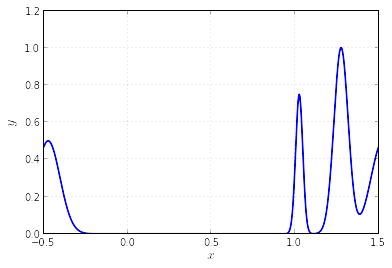

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import convergence_routines

a, b, c, d = 3/4., 1, 1/2., 1/2.
w_a, w_b, w_c, w_d = 0.03, 0.06, 0.1, 0.1
x_a, x_b, x_c, x_d = -1.025, -1.275, -1.525, 0.475 # shift distribution by 1.275 units right

ax, bx = -0.5, 1.5
x = np.linspace(ax, bx,1000)
f = a * np.exp(-((x + x_a) / w_a) ** 2) + b*np.exp(-(((x + x_b)/w_b)**2)) + c*np.exp(-((x + x_c)/w_c) ** 2) + d*np.exp(-((x + x_d)/w_d) ** 2)
                                                 
plt.plot(x,f,'-b', linewidth = 2)
plt.grid()
plt.xlabel('$x$', fontsize = 14)
plt.ylabel('$y$', fontsize = 14)

# CS convergence tests

### Observation 1: (non-edge) CS correction to $LTE[CS] = O(\Delta x^{15})$ is observed, whereafter the error saturates at machine precision too early to observe higher orders

From previous CS convergence tests, we report analysis of the results below for the above domain with meshes labelled by the number of points $N_x$, note the converged error is the global error = LTE - 1. Here, we have chosen a problem characterized by $v = 0.5$

order calculations at each refinement step: LTE order = 12
Nx24        error = 0.112811       ----
Nx48        error = 0.0505444       order = 1.15829
Nx96        error = 0.00552346       order = 3.19391
Nx192        error = 0.000129833       order = 5.41084
Nx384        error = 1.63304e-07       order = 9.63488
Nx768        error = 9.90644e-11       order = 10.6869
Nx1536        error = 5.14652e-14       order = 10.9106


order calculations at each refinement step: LTE order = 13
Nx24        error = 0.106422       ----
Nx48        error = 0.0488786       order = 1.12252
Nx96        error = 0.0050527       order = 3.27408
Nx192        error = 9.51438e-05       order = 5.7308
Nx384        error = 6.96411e-08       order = 10.416
Nx768        error = 2.20093e-11       order = 11.6276
Nx1536        error = 1.71158e-14       order = 10.3286


order calculations at each refinement step: LTE order = 14
Nx24        error = 0.10625       ----
Nx48        error = 0.0485198       order = 1.13082

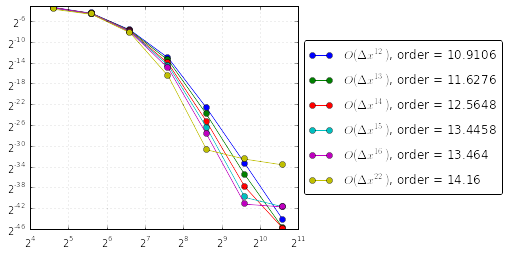

In [4]:
run convergence_plots_several_orders_non-edge_cases

Convincingly, $LTE[CS] = O(\Delta x^{14})$ is achievable, perhaps even $LTE[CS] = O(\Delta x^{15})$, though attempting to correct it any higher is not observed. Note that even for attempts to correct up to order 22, at refined enough meshes, the error from one mesh to the next is not inaccurate (within 2 orders of machine precision for $N_x \sim 10^3$ for example, is at machine precision for $N_x = 768$ at $O(\Delta x^{16})$, and so on). That is, numerical sources of error for FD derivatives computed in regions far from the edge do not seem to come into play.

### Observation 2: (edge) CS correction to at most $LTE[CS] = O(\Delta x^{10})$ is observed, whereafter the error <i>increases<i> for attempts at even higher order correction

From previous CS convergence tests, we report analysis of the results below for the above domain with meshes labelled by the number of points $N_x$, note the converged error is the global error = LTE - 1. Here, we have chosen a problem characterized by $v = 0.5$

order calculations at each refinement step: LTE order = 8
Nx24        error = 0.0675141       ----
Nx48        error = 0.0161712       order = 2.06176
Nx96        error = 0.00914501       order = 0.822374
Nx192        error = 0.000551128       order = 4.05252
Nx384        error = 6.74899e-06       order = 6.35157
Nx768        error = 5.67283e-08       order = 6.89446
Nx1536        error = 4.58163e-10       order = 6.95206


order calculations at each refinement step: LTE order = 9
Nx24        error = 0.0933791       ----
Nx48        error = 0.0177063       order = 2.39883
Nx96        error = 0.0173742       order = 0.0273181
Nx192        error = 0.000437815       order = 5.31048
Nx384        error = 2.03932e-06       order = 7.74609
Nx768        error = 9.9956e-09       order = 7.67258
Nx1536        error = 4.0101e-11       order = 7.96151


order calculations at each refinement step: LTE order = 10
Nx24        error = 0.101172       ----
Nx48        error = 0.020281       order = 2.31

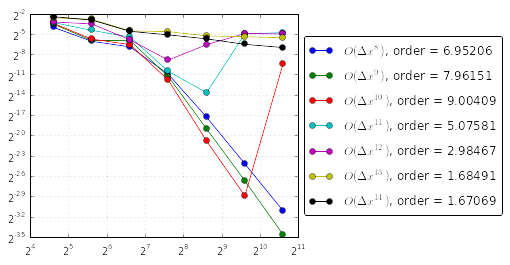

In [5]:
run convergence_plots_several_orders_edge_cases.py

The errors in the non-convergent regions (mesh is too refined) are quite large! By our attempts to correct $LTE[CS] - O(\Delta x^{14})$), the CS solution produces significant error $\sim 10^{-3}$ as compared to the exact solution. In fact, looking at the CS solution at this final time looks more like the classical (uncorrected) CS solution than their high order counterparts. This could be representative of unintended switching on of the limiter which acts as a last line of defense against "overcorrections" ($U_i$ > 1), and acts as a compensatory mechanism to assign either a value of $U_i = \pm 1$ or $U_i = 0$ as needed. If this is not representative of the optimized MC postpoint location, we artificially mismanage density reappropriation in the remapping step by consequence.

# How convergence fails: FD derivative analysis of non-edge vs. edge cases

## FD derivative analysis: non-edge density example, $LTE[CS] = O(\Delta x^{14}$)

We choose an example where the non-edge case succeeds in correcting CS to proper order, but which fails when attempted with an edge case. These two scenarios are meant to be interpreted of snapshots of the same density, since the advection tests only failed when the density was allowed to reach the edges of the domain in the convergence analysis. First, we show the non-edge case (here), then juxtapose with the edge case below and expect to witness a change in FD derivative convergence (i.e. inaccurate derivative calculations) in the edge cases as compared to the non-edge.

First generate the required FD tables, then run a convergence routines:

In [6]:
cd bin/

/home/dsirajud/Work/IPython-notebooks/Convergence of FD formulation of high order CS/pyfiles/bin


In [7]:
import generate_tables_of_finite_difference_schemes_for_a_given_LTE_on_CS

generate_tables_of_finite_difference_schemes_for_a_given_LTE_on_CS.main(LTE_CS = 14)

In [8]:
cd ..

/home/dsirajud/Work/IPython-notebooks/Convergence of FD formulation of high order CS/pyfiles


Note that $LTE[CS] = O(\Delta x^{14})$ was observed just above to converge arond $N_x = 768 \sim 2^{9.58}$, thus we anticipate the derivatives to all be convergent in a vicinity of meshes characterized by this number of grid points for this non-edge density.

### Convergent zones of all FD derivatives needed at the requisite LTE for $LTE[CS] = O(\Delta x^{14})$

See plots at bottom of output

dn = 1, required LTE = 12
a central differencing scheme exists: LTE between 12 and 13 expected if density far from edges

order calculations at each refinement step:
Nx24        error = 150.257       ----
Nx48        error = 299.643       order = -0.995815
Nx96        error = 0.310298       order = 9.91538
Nx192        error = 0.000677468       order = 8.83929
Nx384        error = 4.26202e-07       order = 10.6344
Nx768        error = 1.34692e-10       order = 11.6277
Nx1536        error = 1.14902e-11       order = 3.5512


dn = 2, required LTE = 11
a central differencing scheme exists: LTE between 11 and 12 expected if density far from edges

order calculations at each refinement step:
Nx24        error = 11137.6       ----
Nx48        error = 42144.1       order = -1.91989
Nx96        error = 81.4079       order = 9.01595
Nx192        error = 0.018086       order = 12.1361
Nx384        error = 1.07657e-05       order = 10.7142
Nx768        error = 3.357

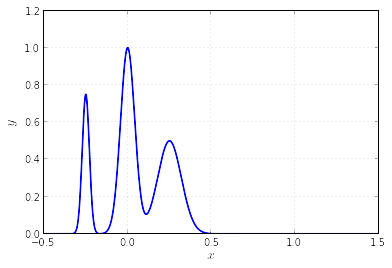

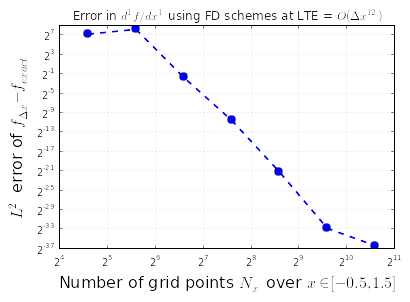

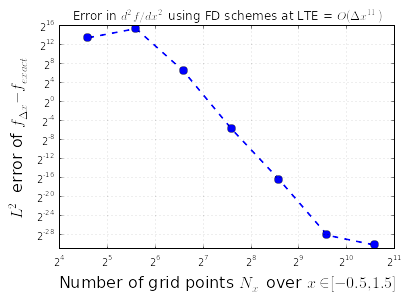

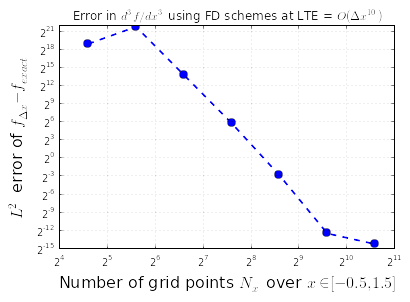

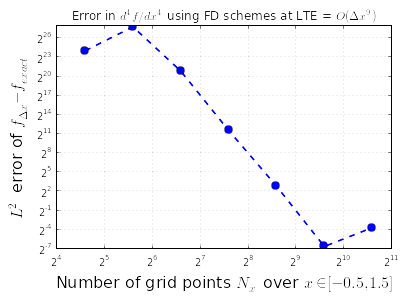

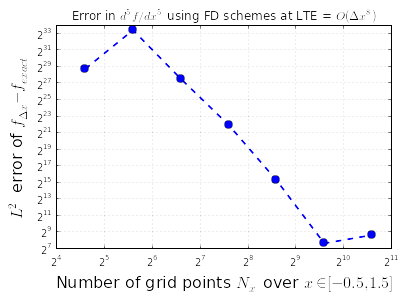

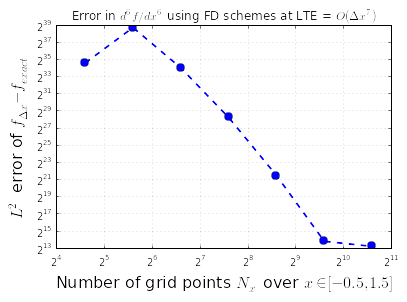

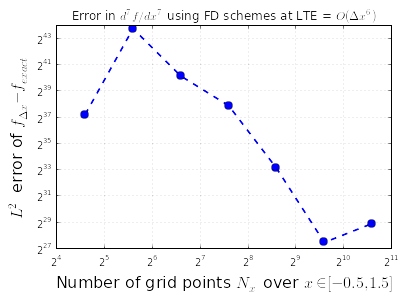

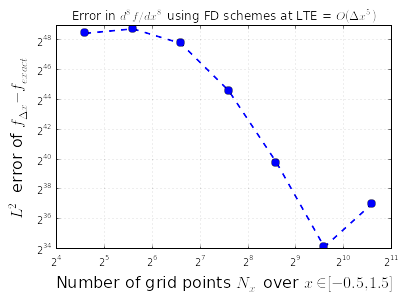

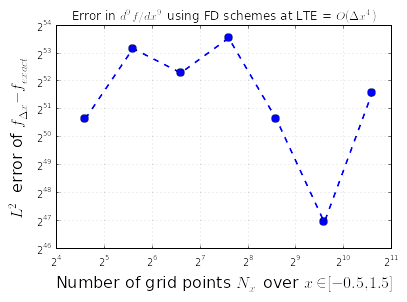

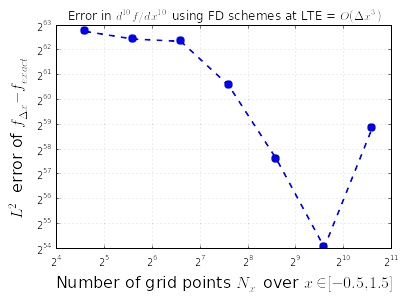

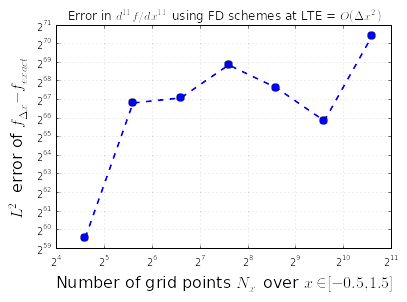

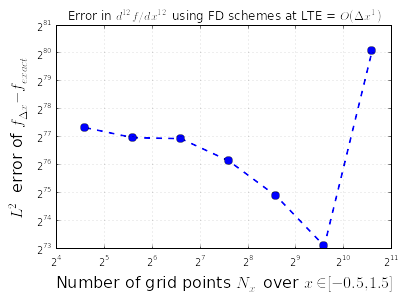

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from convergence_routines import convergence_routine_nonperiodic

# initial density
x = np.linspace(-0.5,1.5,1000)
f = convergence_routines.function(x)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,f,'-b', linewidth = 2)
ax.grid()
plt.xlabel('$x$', fontsize = 14)
plt.ylabel('$y$', fontsize = 14)

LTE_CS = 14
N = LTE_CS - 1

print "See plots at bottom of output\n"
for dn in range(1,N):
    print "dn = %d, required LTE = %d" % (dn, N - dn)
    dummy_out1, dummy_out2 = convergence_routine_nonperiodic(NumGrids = 7, Nx = 24, LTE = N - dn, dn = dn, plots = 'yes')

Consistent with the output above, which shows convergence in the range $N_x = 384 (\sim 2^{8.58})$ to $N_x = 1536 (\sim 2^{10.58})$, the above derivatives are <i>all<i> (within tolerance) convergent in this zone only.

## FD derivative analysis: edge density example, $LTE[CS] = O(\Delta x^{14}$) [failing case]

We analyze the FD derivatives for the edge case, and assess convergent zones for the FD derivatives, expecting to see some signifant failure for every mesh in one or more derivatives converging. This would explain the inaccurate CS estimates. Note, when viewing the output below, what is needed is that the derivatives achieve convergence to the requisite LTE listed.

See plots at bottom of output

dn = 1, required LTE = 12
a central differencing scheme exists: LTE between 12 and 13 expected if density far from edges

order calculations at each refinement step:
Nx24        error = 90.8374       ----
Nx48        error = 6.42762       order = 3.82093
Nx96        error = 0.158194       order = 5.34452
Nx192        error = 0.000677468       order = 7.86733
Nx384        error = 4.26498e-07       order = 10.6334
Nx768        error = 5.6577e-09       order = 6.23618
Nx1536        error = 2.65493e-09       order = 1.09154


dn = 2, required LTE = 11
a central differencing scheme exists: LTE between 11 and 12 expected if density far from edges

order calculations at each refinement step:
Nx24        error = 6562.71       ----
Nx48        error = 982.19       order = 2.74022
Nx96        error = 16.6564       order = 5.88185
Nx192        error = 0.0180886       order = 9.84678
Nx384        error = 1.97265e-05       order = 9.84073
Nx768        error = 1.15128e

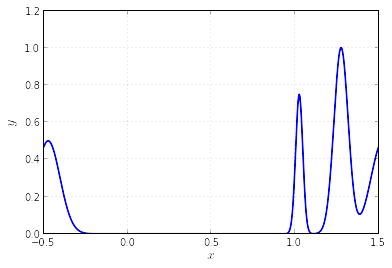

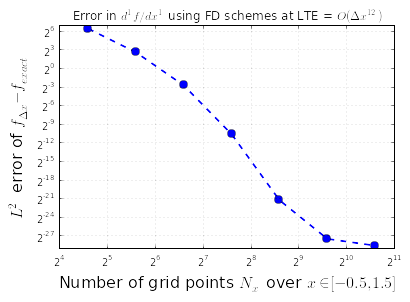

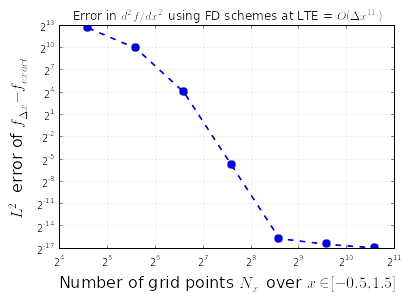

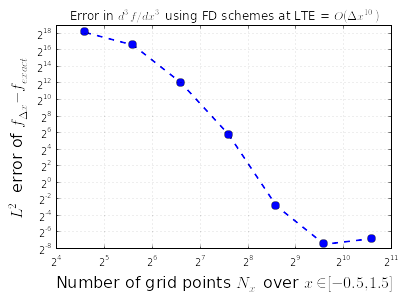

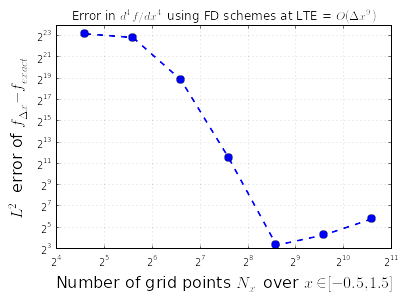

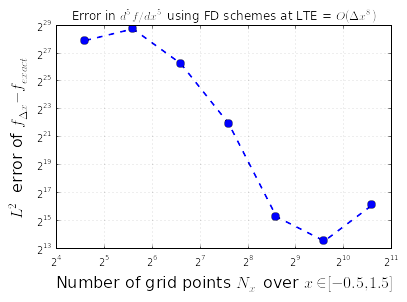

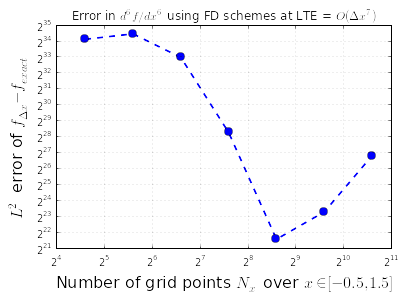

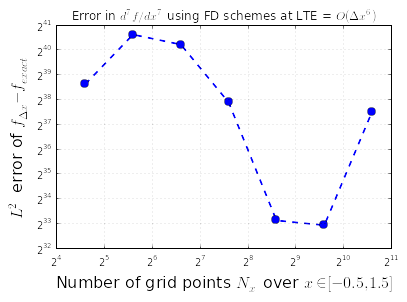

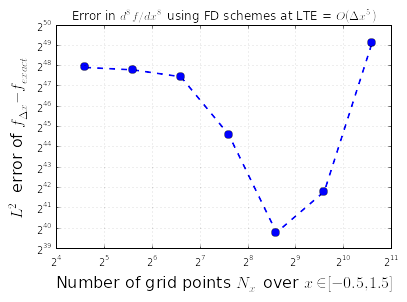

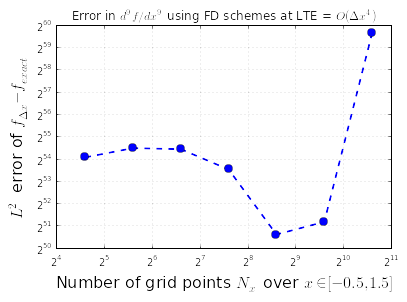

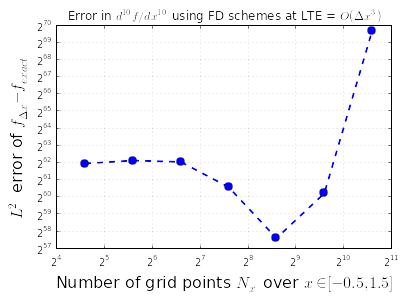

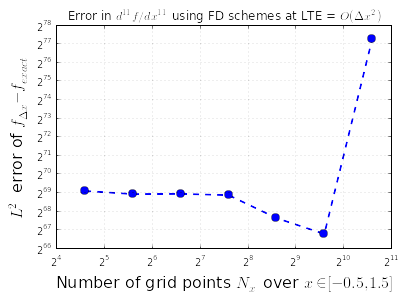

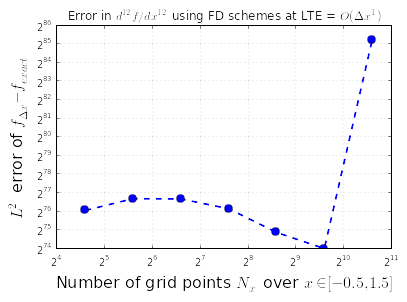

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from convergence_routines import convergence_routine_nonperiodic
     
f = convergence_routines.function_edge(x)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,f,'-b', linewidth = 2)
ax.grid()
plt.xlabel('$x$', fontsize = 14)
plt.ylabel('$y$', fontsize = 14)
  
print "See plots at bottom of output\n"
for dn in range(1,N):
    print "dn = %d, required LTE = %d" % (dn, N-dn)
    dummy_out1, dummy_out2 = convergence_routine_nonperiodic(NumGrids = 7, Nx = 24, LTE = N - dn, dn = dn, plots = 'yes', edge = 'yes')

It turns out <b>only 2 out of 12</b> FD derivatives ($dn = 10, 12$, perhaps even $dn = 8$) converge for this challenging density. In particular, we note the previously observed trends: the <i>lower</i> order derivatives that have the highest $LTE$ requirement as well as the <i>higher</i> order derivatives with the least $LTE$ requirements fail. This trend has been investigated before (perhaps shown in the appendix, if desire permits)

# Conclusions

For the test density investigated, correcting CS relies on accurate enough estimations of derivatives up to order $N-1$ for a targetted LTE on CS of order $N+1$. We have shown that while this is no problem for compact densities far from edges, it is significantly hampered when a large degree of variation takes place near the edges where asymmetric FD schemes are relied upon. According to the test case here, these asymmetric schemes fail to achieve the requisite density required for correcting CS to LTE orders greater than 10. This was proven by analyzing the derivatives for the density far from the edges as compared to the same density cut by the right-edge boundary. The derivatives for these latter ("edge") cases, do not have most of their derivatives converge, which is posited to inappropriately trigger the limiter (filter) used on restraining the value of the correction factor $U$ (depends on derivatives) so that it unphysically pushes packets of density to postpoints as a compensation for incorrect $U$ calculations provided by incorrect derivative estimates by FD schemes. The appendices that follow explore some trends, as well as look in more detail at the advection through the boundary (Appendix E).

# Appendix A

## Proving the analytical derivatives are derived correctly by comparison with FD estimates

We plot all the derivatives alongside their FD estimates. Since the edge densities are the same exact form as the non-edge cases, we do not require exhaustively showing agreement for both cases (and as shown above, the edge cases do not agree), but suffice to show the non-edge cases

### $dn = 1$, non-edge

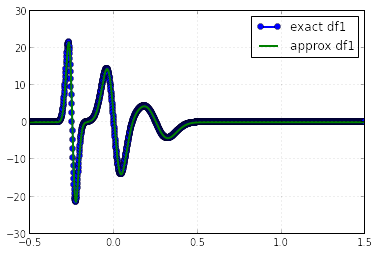

In [11]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df1

x, dx, L = domain(_Nx = 1344) # Nx = 1344 shows convergent FD derivative from above output
L2error, df1_approx = FD_derivative_matrix_formulation(_dn = 1, _p = 3, _Nx = 1344)
df1_exact = df1(x)

plt.plot(x,df1_exact, label = 'exact df1', marker = 'o', linewidth = 2)
plt.hold('on')
plt.plot(x,df1_approx, label = 'approx df1', linewidth = 2)
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 1$, edge

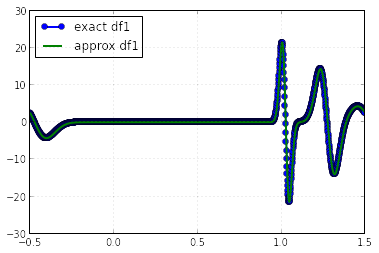

In [12]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df1_edge

x, dx, L = domain(_Nx = 1344) # Nx = 1344 shows convergent FD derivative from above output
L2error, df1_approx = FD_derivative_matrix_formulation(_dn = 1, _p = 3, _Nx = 1344, edge = 'yes')
df1_exact = df1_edge(x)

plt.plot(x,df1_exact, label = 'exact df1', marker = 'o', linewidth = 2)
plt.hold('on')
plt.plot(x,df1_approx, label = 'approx df1', linewidth = 2)
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 2$, non-edge

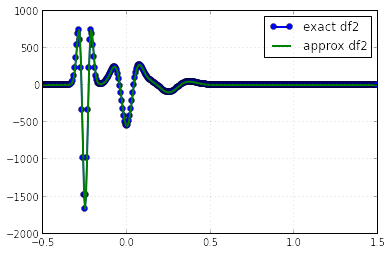

In [13]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df2

x, dx, L = domain(_Nx = 336) # Nx = 336 shows convergent FD derivative from above output
L2error, df2_approx = FD_derivative_matrix_formulation(_dn = 2, _p = 3, _Nx = 336)
df2_exact = df2(x)

plt.plot(x,df2_exact, label = 'exact df2', marker = 'o', linewidth = 2)
plt.hold('on')
plt.plot(x,df2_approx, label = 'approx df2', linewidth = 2)
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 2$, edge

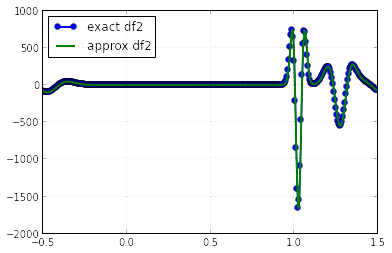

In [14]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df2_edge

x, dx, L = domain(_Nx = 336) # Nx = 336 shows convergent FD derivative from above output
L2error, df2_approx = FD_derivative_matrix_formulation(_dn = 2, _p = 3, _Nx = 336, edge= 'yes')
df2_exact = df2_edge(x)

plt.plot(x,df2_exact, label = 'exact df2', marker = 'o', linewidth = 2)
plt.hold('on')
plt.plot(x,df2_approx, label = 'approx df2', linewidth = 2)
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 3$, non-edge

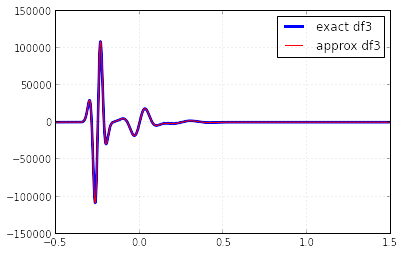

In [15]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df3

x, dx, L = domain(_Nx = 2688) # Nx = 2688 shows not convergence, but a saturated error
L2error, df3_approx = FD_derivative_matrix_formulation(_dn = 3, _p = 3, _Nx = 2688)
df3_exact = df3(x)

plt.plot(x,df3_exact, label = 'exact df3', linewidth = 3)
plt.hold('on')
plt.plot(x,df3_approx, label = 'approx df3', linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 3$, edge

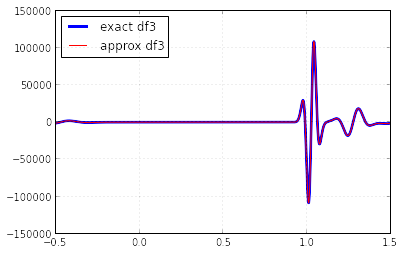

In [16]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df3_edge

x, dx, L = domain(_Nx = 2688) # Nx = 2688 shows not convergence, but a saturated error
L2error, df3_approx = FD_derivative_matrix_formulation(_dn = 3, _p = 3, _Nx = 2688, edge = 'yes')
df3_exact = df3_edge(x)

plt.plot(x,df3_exact, label = 'exact df3', linewidth = 3)
plt.hold('on')
plt.plot(x,df3_approx, label = 'approx df3', linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 4$, non-edge

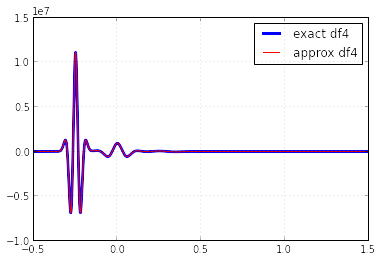

In [17]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df4

x, dx, L = domain(_Nx = 2688) # Nx = 2688 shows not convergence, but a saturated error
L2error, df4_approx = FD_derivative_matrix_formulation(_dn = 4, _p = 3, _Nx = 2688)
df4_exact = df4(x)

plt.plot(x,df4_exact, label = 'exact df4', linewidth = 3)
plt.hold('on')
plt.plot(x,df4_approx, label = 'approx df4', linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 4$, edge

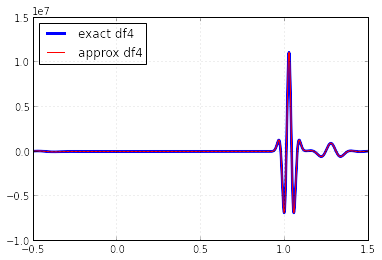

In [18]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df4_edge

x, dx, L = domain(_Nx = 2688) # Nx = 2688 shows not convergence, but a saturated error
L2error, df4_approx = FD_derivative_matrix_formulation(_dn = 4, _p = 3, _Nx = 2688, edge= 'yes')
df4_exact = df4_edge(x)

plt.plot(x,df4_exact, label = 'exact df4', linewidth = 3)
plt.hold('on')
plt.plot(x,df4_approx, label = 'approx df4', linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 5$, non-edge

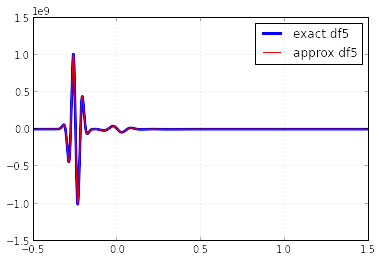

In [19]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df5

x, dx, L = domain(_Nx = 2688) # Nx = 2688 shows not convergence, but a saturated error
L2error, df5_approx = FD_derivative_matrix_formulation(_dn = 5, _p = 3, _Nx = 2688)
df5_exact = df5(x)

plt.plot(x,df5_exact, label = 'exact df5', linewidth = 3)
plt.hold('on')
plt.plot(x,df5_approx, label = 'approx df5', linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 5$, edge

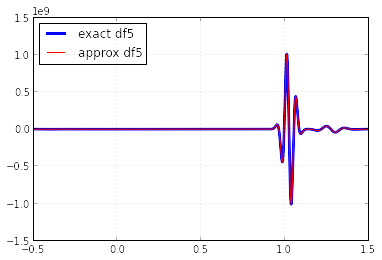

In [20]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df5_edge

x, dx, L = domain(_Nx = 2688) # Nx = 2688 shows not convergence, but a saturated error
L2error, df5_approx = FD_derivative_matrix_formulation(_dn = 5, _p = 3, _Nx = 2688, edge = 'yes')
df5_exact = df5_edge(x)

plt.plot(x,df5_exact, label = 'exact df5', linewidth = 3)
plt.hold('on')
plt.plot(x,df5_approx, label = 'approx df5', linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 6$, non-edge

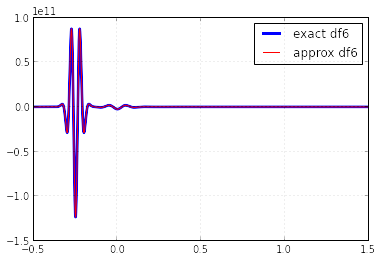

In [21]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df6

x, dx, L = domain(_Nx = 2688) # Nx = 2688 shows not convergence, but a saturated error
L2error, df6_approx = FD_derivative_matrix_formulation(_dn = 6, _p = 3, _Nx = 2688)
df6_exact = df6(x)

plt.plot(x,df6_exact, label = 'exact df6', linewidth = 3)
plt.hold('on')
plt.plot(x,df6_approx, label = 'approx df6', linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 6$, edge

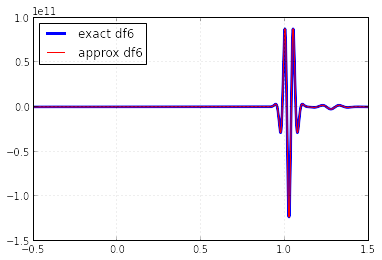

In [22]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df6_edge

x, dx, L = domain(_Nx = 2688) # Nx = 2688 shows not convergence, but a saturated error
L2error, df6_approx = FD_derivative_matrix_formulation(_dn = 6, _p = 3, _Nx = 2688, edge = 'yes')
df6_exact = df6_edge(x)

plt.plot(x,df6_exact, label = 'exact df6', linewidth = 3)
plt.hold('on')
plt.plot(x,df6_approx, label = 'approx df6', linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 7$, non-edge

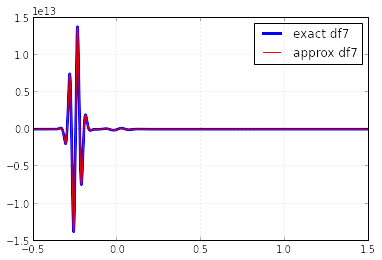

In [23]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df7

x, dx, L = domain(_Nx = 2688) # Nx = 2788 shows not convergence, but a saturated error
L2error, df7_approx = FD_derivative_matrix_formulation(_dn = 7, _p = 3, _Nx = 2688)
df7_exact = df7(x)

plt.plot(x,df7_exact, label = 'exact df7', linewidth = 3)
plt.hold('on')
plt.plot(x,df7_approx, label = 'approx df7', linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 7$, edge

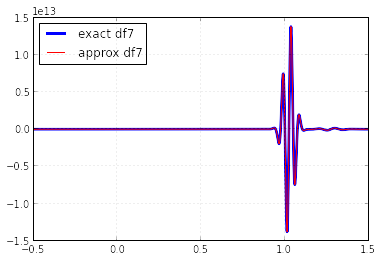

In [24]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df7_edge

x, dx, L = domain(_Nx = 2688) # Nx = 2788 shows not convergence, but a saturated error
L2error, df7_approx = FD_derivative_matrix_formulation(_dn = 7, _p = 3, _Nx = 2688, edge= 'yes')
df7_exact = df7_edge(x)

plt.plot(x,df7_exact, label = 'exact df7', linewidth = 3)
plt.hold('on')
plt.plot(x,df7_approx, label = 'approx df7', linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 8$, non-edge

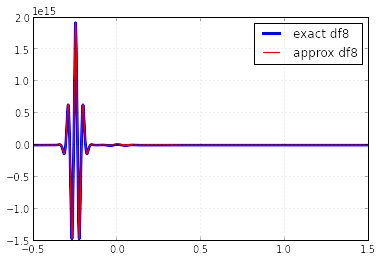

In [25]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df8

x, dx, L = domain(_Nx = 2688) # Nx = 2888 shows not convergence, but a saturated error
L2error, df8_approx = FD_derivative_matrix_formulation(_dn = 8, _p = 3, _Nx = 2688)
df8_exact = df8(x)

plt.plot(x,df8_exact, label = 'exact df8', linewidth = 3)
plt.hold('on')
plt.plot(x,df8_approx, label = 'approx df8', linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 8$, edge

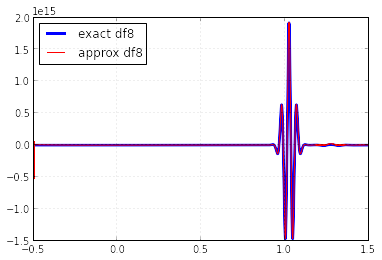

In [26]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df8_edge

x, dx, L = domain(_Nx = 2688) # Nx = 2888 shows not convergence, but a saturated error
L2error, df8_approx = FD_derivative_matrix_formulation(_dn = 8, _p = 3, _Nx = 2688, edge = 'yes')
df8_exact = df8_edge(x)

plt.plot(x,df8_exact, label = 'exact df8', linewidth = 3)
plt.hold('on')
plt.plot(x,df8_approx, label = 'approx df8', linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 9$, non-edge

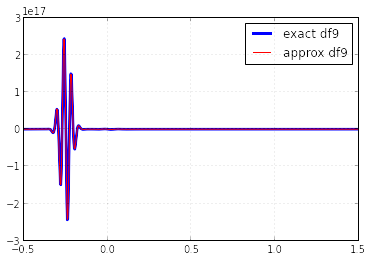

In [27]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df9

x, dx, L = domain(_Nx = 672) # Nx = 2999 shows not convergence, but a saturated error
L2error, df9_approx = FD_derivative_matrix_formulation(_dn = 9, _p = 3, _Nx = 672)
df9_exact = df9(x)

plt.plot(x,df9_exact, label = 'exact df9', linewidth = 3)
plt.hold('on')
plt.plot(x,df9_approx, label = 'approx df9', linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 9$, edge

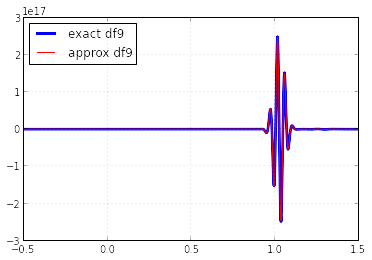

In [28]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df9_edge

x, dx, L = domain(_Nx = 672) # Nx = 2999 shows not convergence, but a saturated error
L2error, df9_approx = FD_derivative_matrix_formulation(_dn = 9, _p = 3, _Nx = 672, edge = 'yes')
df9_exact = df9_edge(x)

plt.plot(x,df9_exact, label = 'exact df9', linewidth = 3)
plt.hold('on')
plt.plot(x,df9_approx, label = 'approx df9', linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 10$, non-edge

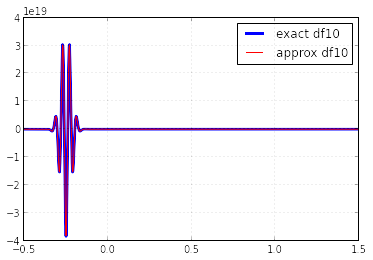

In [29]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df10

Nx = 672
x, dx, L = domain(_Nx = Nx) 
L2error, df10_approx = FD_derivative_matrix_formulation(_dn = 10, _p = 3, _Nx = Nx)
df10_exact = df10(x)

plt.plot(x,df10_exact, label = 'exact df10', linewidth = 3)
plt.hold('on')
plt.plot(x,df10_approx, label = 'approx df10', linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 10$, edge

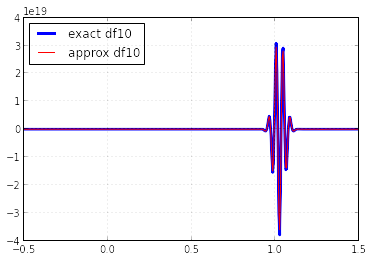

In [30]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df10_edge

Nx = 384
x, dx, L = domain(_Nx = Nx) 
L2error, df10_approx = FD_derivative_matrix_formulation(_dn = 10, _p = 3, _Nx = Nx, edge = 'yes')
df10_exact = df10_edge(x)

plt.plot(x,df10_exact, label = 'exact df10', linewidth = 3)
plt.hold('on')
plt.plot(x,df10_approx, label = 'approx df10', linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 11$, non-edge

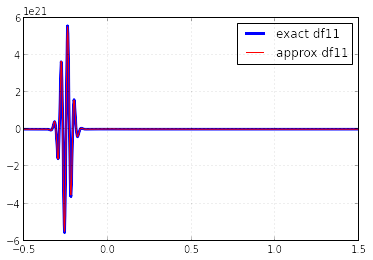

In [31]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df11

Nx = 672
x, dx, L = domain(_Nx = Nx) 
L2error, df11_approx = FD_derivative_matrix_formulation(_dn = 11, _p = 3, _Nx = Nx)
df11_exact = df11(x)

plt.plot(x,df11_exact, label = 'exact df11', linewidth = 3)
plt.hold('on')
plt.plot(x,df11_approx, label = 'approx df11', linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 11$, edge

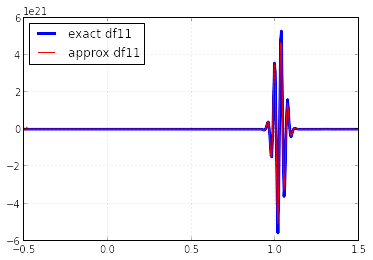

In [32]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df11_edge

Nx = 384
x, dx, L = domain(_Nx = Nx) 
L2error, df11_approx = FD_derivative_matrix_formulation(_dn = 11, _p = 3, _Nx = Nx, edge = 'yes')
df11_exact = df11_edge(x)

plt.plot(x,df11_exact, label = 'exact df11', linewidth = 3)
plt.hold('on')
plt.plot(x,df11_approx, label = 'approx df11', linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 12$, non-edge

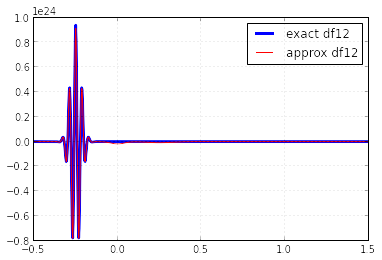

In [33]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df12

Nx = 672
x, dx, L = domain(_Nx = Nx) 
L2error, df12_approx = FD_derivative_matrix_formulation(_dn = 12, _p = 3, _Nx = Nx)
df12_exact = df12(x)

plt.plot(x,df12_exact, label = 'exact df12', linewidth = 3)
plt.hold('on')
plt.plot(x,df12_approx, label = 'approx df12', linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

### $dn = 12$, edge

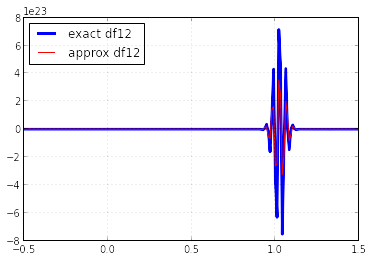

In [34]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df12_edge

Nx = 192
x, dx, L = domain(_Nx = Nx) 
L2error, df12_approx = FD_derivative_matrix_formulation(_dn = 12, _p = 3, _Nx = Nx, edge = 'yes')
df12_exact = df12_edge(x)

plt.plot(x,df12_exact, label = 'exact df12', linewidth = 3)
plt.hold('on')
plt.plot(x,df12_approx, label = 'approx df12', linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

Notice how few points have to be used in the higher order $dn$ derivatives, including more points produces unphysical features in the edge cases:

### $dn = 12$, edge, high $N_x = 2688$

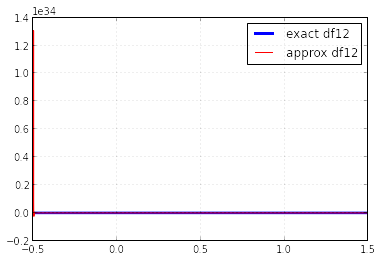

In [35]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df12_edge

Nx = 2688
x, dx, L = domain(_Nx = Nx) 
L2error, df12_approx = FD_derivative_matrix_formulation(_dn = 12, _p = 3, _Nx = Nx, edge = 'yes')
df12_exact = df12_edge(x)

plt.plot(x,df12_exact, label = 'exact df12', linewidth = 3)
plt.hold('on')
plt.plot(x,df12_approx, label = 'approx df12', linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.grid()

# Appendix B: convergence trends in derivatives

## 1. Convergence zones shrink with mesh size (constant LTE = $O(\Delta x^3)$ shown here)

The purpose of this section is to prove the range of permissible mesh spacings for convergence decreases with increasing derivative number $dn$, $\partial_x^{dn}f$

In [36]:
cd bin/

/home/dsirajud/Work/IPython-notebooks/Convergence of FD formulation of high order CS/pyfiles/bin


In [37]:
import generate_tables_of_finite_difference_schemes_for_a_given_LTE_for_range_of_derivatives

generate_tables_of_finite_difference_schemes_for_a_given_LTE_for_range_of_derivatives.main(LTE = 3, dn_min = 1, dn_max = 12)

In [38]:
cd ..

/home/dsirajud/Work/IPython-notebooks/Convergence of FD formulation of high order CS/pyfiles


Explore the first 12 derivatives for the non-edge case

derivative dn = 1: 

no central differencing scheme exists: LTE of 3 expected

order calculations at each refinement step:
Nx21        error = 4.4494       ----
Nx42        error = 3.84225       order = 0.211659
Nx84        error = 0.992643       order = 1.9526
Nx168        error = 0.163587       order = 2.60121
Nx336        error = 0.0223381       order = 2.87249
Nx672        error = 0.00285612       order = 2.96738
Nx1344        error = 0.000359051       order = 2.9918
Nx2688        error = 4.49453e-05       order = 2.99795
Nx5376        error = 5.62016e-06       order = 2.99949
Nx10752        error = 7.02583e-07       order = 2.99987


derivative dn = 2: 

a central differencing scheme exists: LTE between 3 and 4 expected if density far from edges

order calculations at each refinement step:
Nx21        error = 186.714       ----
Nx42        error = 108.342       order = 0.785237
Nx84        error = 18.5359       order = 2.5472
Nx168        error = 2.69061       order = 2.78432
Nx33

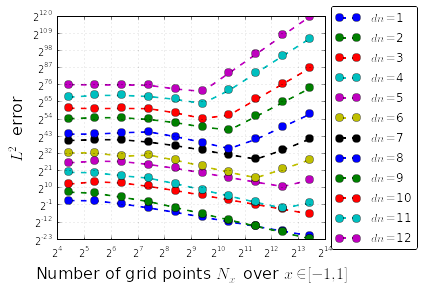

In [39]:
%matplotlib inline
import convergence_routines

convergence_routines.convergence_for_several_derivatives_at_const_LTE(NumGrids = 10, _LTE = 3, _dn_min = 1,
                                                                      _dn_max = 12, plots = 'no')


As usual, for schemes that have an odd stencil (size = LTE + dn, e.g. dn = 2, 4), we anticipate a higher order of accuracy since the existence of a central schemes in odd stencils furnishes a fortuitous cancellation of exactly one extra term in the LTE, raising its order of accuracy. Since the most centered scheme is used for the majority of the domain (internal nodes, away from edges), the observed order is closer to this $p+1 = 4$ convergence than to the bottom line of $p = 3$ that was queried in the script run for such a FD generation scheme. For the other derivatives (dn = 1, 3), we expect order $O(\Delta x^3)$. All of these are observed, and we do note that for dn = 4, we observe a trend that was observed in the notebook "Convergence of FD calculations of derivatives", i.e. there exist optimal ranges for mesh resolution, beyond such a threshold a term that scales with the derivative $O(\Delta x^{-dn})$ and is proportional to the machine error $\epsilon \sim 10^{-16}$ can compete with the decreasing LTE term, and dominates. Such a region causes a deviation, as previously investigated, from convergence, and generally a mesh this refined with respect to a particular derivative should be avoided to preclude numerical error from contaminating the global solution; however, it is clear that the ultimate bottom line is not convergence of the derivatives, but to ensure we do not operate in a region where the error is not agreeable. That is, we may choose a mesh that dips into the region with positive slope on the above plot ($L^2$ error vs. mesh), and while these can be regarded as troubled waters, so long as the error is still quite small we do not incur any consequences. To that end, we note that this knowledge for a particular problem with an evolving density function cannot be predicted a priori, and make note that should inconsistencies be present, the "corrections" added to final position of a moving cell in CS (which come from higher order derivatives) can be a culprit.

## 2. Convergence zones shrink with increasing LTE (constant $dn = 8$ shown)

In [40]:
cd bin/

/home/dsirajud/Work/IPython-notebooks/Convergence of FD formulation of high order CS/pyfiles/bin


In [41]:
import generate_tables_of_finite_difference_schemes_for_a_given_LTE

for LTE in range(1,8+1):
    generate_tables_of_finite_difference_schemes_for_a_given_LTE.main(LTE = LTE, dn = 8)

In [42]:
cd ..

/home/dsirajud/Work/IPython-notebooks/Convergence of FD formulation of high order CS/pyfiles


dn = 8
LTE = 1: central scheme exists (order between 1 and 2 expected) 

a central differencing scheme exists: LTE between 1 and 2 expected if density far from edges

order calculations at each refinement step:
Nx21        error = 2.76998e+13       ----
Nx42        error = 2.67981e+13       order = 0.0477456
Nx84        error = 3.95212e+13       order = -0.560498
Nx168        error = 1.32362e+14       order = -1.74379
Nx336        error = 4.6357e+13       order = 1.51363
Nx672        error = 1.27367e+13       order = 1.8638
Nx1344        error = 3.2625e+12       order = 1.96493
Nx2688        error = 8.74041e+11       order = 1.90021
Nx5376        error = 6.39426e+13       order = -6.19293
Nx10752        error = 1.63535e+16       order = -7.99861


LTE = 2: 

no central differencing scheme exists: LTE of 2 expected

order calculations at each refinement step:
Nx21        error = 2.7703e+13       ----
Nx42        error = 2.69089e+13       order = 0.0419566
Nx84        error = 3.95226e+13

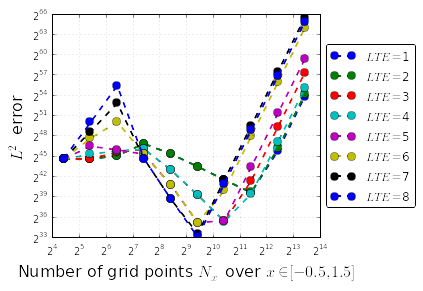

In [43]:
import convergence_routines

print "dn = %d" % 8
convergence_routines.convergence_for_a_single_derivative_at_several_LTE(NumGrids = 10, _dn = 8, _LTE_min = 1, _LTE_max = 8, plots = 'no')

Tracking the width of convergent regions in terms of the number of mesh points $N_x$ over this domain $x\in [-0.5, 1.5]$, we note that the start of the convergent region for all LTEs are at $N_x = 168$, yet with higher LTE the end point at which convergent estimates are achievable recedes, beginning at the upper bound of $N_x = 2688$. We track the convergent regions in terms of the permissible widths $\Delta x$:

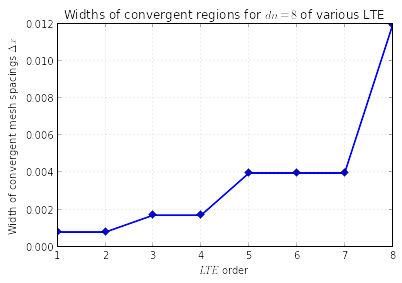

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Nx_convergent_regions = np.zeros(8+1)

# these values are just transcribed by viewing the above outputs
Nx_convergent_regions[1] = 2688 - 168
Nx_convergent_regions[2] = 2688 - 168
Nx_convergent_regions[3] = 1344 - 168
Nx_convergent_regions[4] = 1344 - 168
Nx_convergent_regions[5] = 672 - 168
Nx_convergent_regions[6] = 672 - 168
Nx_convergent_regions[7] = 672 - 168
Nx_convergent_regions[8] = 336 - 168

plt.plot(range(1,8+1), 2./Nx_convergent_regions[1:], marker = 'D', linewidth = 2)
plt.grid()
plt.title('Widths of convergent regions for $dn = 8$ of various LTE')
plt.xlabel('$LTE$ order')
plt.ylabel('Width of convergent mesh spacings $\Delta x$')


# Appendix C: How FD estimations fail ($LTE = O(\Delta x^3)$ shown here)

## 1. Performance of convergent FD derivatives

Regarding the convergence output from B.1 above, the lowest order derivatives ($dn = 1, 2, \ldots$), the finite difference estimations are seen to mimick very accurately the curvature of the exact derivative, this speaks on the numerical error term scales too slowly as compared to the LTE for low derivative numbers ($\partial_x^1 f, \partial_x^2 f, \partial_x^3 f$), which is consistent with the findings above that these lower derivative numbers have convergent solutions for the entire (large) range of mesh sizes explored.

For orders around $dn = 5$, the numerical error term can catch up with the LTE putting the FD scheme in a mesh where it does not produce a convergent solution. We investigate what the FD estimations produce with respect to the exact derivatives for the case of $\partial_x^5 f$.

### Convergent region: $\partial_x^5 f$ for $LTE = O(\Delta x^3)$, $N_x = 2688$ $\sim 2^{11.39}$

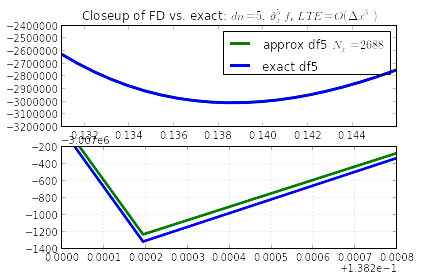

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from convergence_routines import *

# set up side-by-side subplots with differing window ranges

fix, ax = plt.subplots(2,1)

Nx = 2688
x, dx, L = domain(_Nx = Nx)
L2error, df5_approx_Nx2688 = FD_derivative_matrix_formulation(_dn = 5, _p = 3, _Nx = Nx)
ax[0].plot(x,df5_approx_Nx2688, label = 'approx df5 $N_x = 2688$', linewidth = 3, color = "green")
ax[1].plot(x,df5_approx_Nx2688, label = 'approx df5 $N_x = 2688$', linewidth = 3, color = "green")

ax[0].hold('on')
ax[1].hold('on')

df5_exact = df5(x)

ax[0].plot(x,df5_exact, label = 'exact df5', linewidth = 3, color = "blue")
ax[1].plot(x,df5_exact, label = 'exact df5', linewidth = 3, color = "blue")

ax[0].hold('off')
ax[1].hold('off')

# zoom in to see errors from exact (blue)
ax[0].set_xlim([0.131, 0.146])
ax[0].set_ylim([-3.2e6, -2.4e6])

ax[1].set_xlim([0.0002 + 1.38e-1, 0.0010 + 1.38e-1])
ax[1].set_ylim([-1400 - 3.007e6, -200 - 3.007e6])

ax[0].legend(loc = 'best')
ax[0].set_title('Closeup of FD vs. exact: $dn = 5, \, \partial_x^5 f$, $LTE = O(\Delta x^3)$')
plt.grid()


We see the differences in FD estimation (green) compared to the exact (blue) is on the order of $10^6$ in error, this is because of the limited accuracy in the LTE as well as the fact that the derivative itself takes on enormous values so that the percent difference can be modest, but the actual difference is correspondingly large. The curvature is adhered to in the FD estimation and the LTE required is achieved. This kind of circumstance does not prohibit the correction of CS to higher order as it converges.

## 2. Performance of non-convergent FD derivatives

### Non-convergent region (near inflection point): $\partial_x^5 f$ for $LTE = O(\Delta x^3)$, $N_x = 10752$ $\sim 2^{13.39}$

We now juxtapose the top pane of the above subplots $N_x = 2688$ ($\Delta x = 0.000744$) with the same plot as calculated on a finer mesh here  $N_x = 10752$ ($\Delta x = 0.000186$), also compare with the $L^2$ error plots of all derivatives $1 \leq dn \leq 8$ above to see that $N_x = 2688$ is in the convergent region, whereas $N_x = 10752$ is a region where numerical error just begins to compete with the dropoff of error from the LTE. The FD estimation (<font color = "red">red</font>) as compared with the exact (<font color = "blue">blue</font>) adheres to the curvature of the analytical derivative, yet only in its mean value. 

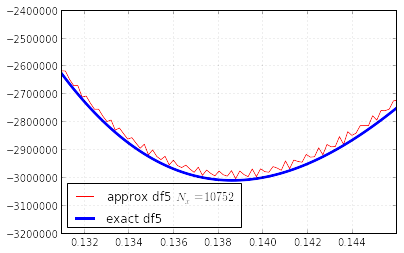

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from convergence_routines import *

Nx = 10752
x, dx, L = domain(_Nx = Nx)
L2error, df5_approx_Nx10752 = FD_derivative_matrix_formulation(_dn = 5, _p = 3, _Nx = Nx)
plt.plot(x,df5_approx_Nx10752, label = 'approx df5 $N_x = 10752$', linewidth = 1, color = "red")
plt.hold('on')

df5_exact = df5(x)
plt.plot(x,df5_exact, label = 'exact df5', linewidth = 3, color = "blue")
plt.hold('off')

# zoom in to see errors from exact (blue)
plt.xlim([0.131, 0.146])
plt.ylim([-3.2e6, -2.4e6])
plt.legend(loc = 'best')
plt.grid()

Note the difference in mesh spacing is only $\sim 5.58\times 10^{-4}$. This is sufficiently resolved to show not only that numerical error contaminates the solution, but shows the manner in which it does in this modest case (i.e. the numerical error does not overwhelmingly dominate, but is large enough to compete with the LTE dropoff). As compared to the $N_x = 2688$ case this, $N_x = 10752$ instance <b>shows unphysical oscillations in the FD estimations.</b>

Overall, the derivative continues the trend globally, where the numerical oscillations are sufficiently local and regular.

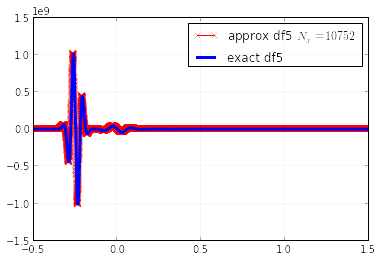

In [47]:
import matplotlib.pyplot as plt
plt.plot(x,df5_approx_Nx10752, label = 'approx df5 $N_x = 10752$', marker = 'x', color = "red")
plt.hold('on')

df5_exact = df5(x)
plt.plot(x,df5_exact, label = 'exact df5', linewidth = 3, color = "blue")
plt.hold('off')
plt.legend(loc = 'best')
plt.grid()

The oscillations for this case produce a maximum error from the exact derivative of 1.33%, whereas the average deviation is measured over the range $x\in [0.13244048, 0.14155506]$ is 0.706427%. This was calculated in this subrange by considering a range of values on the $N_x = 10752$ mesh of:

In [48]:
ix_min = 3400
ix_max = 3450

print "x gridpoints = " + np.array_str(x[ix_min:ix_max])

x gridpoints = [ 0.13244048  0.13262649  0.1328125   0.13299851  0.13318452  0.13337054
  0.13355655  0.13374256  0.13392857  0.13411458  0.1343006   0.13448661
  0.13467262  0.13485863  0.13504464  0.13523065  0.13541667  0.13560268
  0.13578869  0.1359747   0.13616071  0.13634673  0.13653274  0.13671875
  0.13690476  0.13709077  0.13727679  0.1374628   0.13764881  0.13783482
  0.13802083  0.13820685  0.13839286  0.13857887  0.13876488  0.13895089
  0.1391369   0.13932292  0.13950893  0.13969494  0.13988095  0.14006696
  0.14025298  0.14043899  0.140625    0.14081101  0.14099702  0.14118304
  0.14136905  0.14155506]


the absolute and average errors from the exact derivative in this range is

In [49]:
max_error = np.max(df5_exact[ix_min:ix_max] - df5_approx_Nx10752[ix_min:ix_max])
max_ind = ix_min + np.argmax(df5_exact[ix_min:ix_max] - df5_approx_Nx10752[ix_min:ix_max])

min_error = np.min(df5_exact[ix_min:ix_max] - df5_approx_Nx10752[ix_min:ix_max])
min_ind = ix_min + np.argmin(df5_exact[ix_min:ix_max] - df5_approx_Nx10752[ix_min:ix_max])

# record absolute maximum error
if np.abs(max_error) > np.abs(min_error):
    absmax_error = max_error
    absmax_ind = max_ind
else:
    absmax_error = min_error
    absmax_ind = min_ind
    
# record average error
pointwise_frac_diff = (df5_exact[ix_min:ix_max] - df5_approx_Nx10752[ix_min:ix_max]) / df5_exact[ix_min:ix_max]
absmax_frac_error = absmax_error / df5_exact[absmax_ind]

avg_error_percent = np.average(pointwise_frac_diff) * 100
absmax_error_percent = absmax_frac_error * 100
    
print "absolute maximum error has a percent difference from the exact df5: %g%%" % absmax_error_percent
print "average maximum error has a percent difference from the exact df5: %g%%" % avg_error_percent

absolute maximum error has a percent difference from the exact df5: 1.33144%
average maximum error has a percent difference from the exact df5: 0.706427%


In test cases, being in this zone is not detrimental since we are not too deep into the numerical error dominated region. Modest errors like this can sometimes be permissible.

### Non-convergent region (well inside numerical error dominated zone): $\partial_x^5 f$ for $LTE = O(\Delta x^3)$, $N_x = 10752$ $\sim 2^{13.39}$

Electing to examine the 8th derivative permits us to see how deleterious the effect of the numerical error term is on the FD estimation for a mesh spacing where the numerical source term dominates significantly (cf. plot in subsection "Convergence of FD derivatives at constant LTE = $O(\Delta x^3)$"). In the previous section, we showed that dipping into the region where numerical error just begins to dominate produces numerical oscillations of low amplitude ($\sim 0.706\%$ on average), but whose mean value adheres within the order of accuracy of the exact derivative.

The 8th derivative has a convergent region ($N_x$: $2^8 \sim 2^{10}$, equivalently $\Delta x: 0.0078125 \sim 0.00195$, cf. also appendix B.1) as follows:

a central differencing scheme exists: LTE between 3 and 4 expected if density far from edges

order calculations at each refinement step:
Nx21        error = 2.77068e+13       ----
Nx42        error = 2.90511e+13       order = -0.0683525
Nx84        error = 5.38436e+13       order = -0.890181
Nx168        error = 7.57499e+13       order = -0.492469
Nx336        error = 9.16983e+12       order = 3.04628
Nx672        error = 6.89772e+11       order = 3.7327
Nx1344        error = 4.65384e+10       order = 3.88962
Nx2688        error = 2.93417e+12       order = -5.97839
Nx5376        error = 7.45386e+14       order = -7.98889
Nx10752        error = 1.90663e+17       order = -7.99882




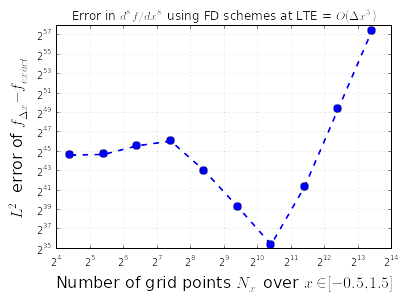

In [50]:
from convergence_routines import convergence_routine_nonperiodic

dummy_out1, dummy_out2 = convergence_routine_nonperiodic(NumGrids = 10, Nx = 21, LTE = 3, dn = 8, plots = 'yes')

$N_x = 672 \sim 2^{9.392}$ is seen to be in the convergent (middle) region, we plot this for a base case

### $N_x = 672$ ($\Delta x = 0.002976$): convergent region

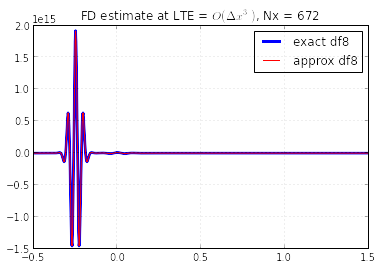

In [51]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df8

Nx = 672
LTE = 3
dn = 8
x, dx, L = domain(_Nx = Nx) # Nx = 336 is in convergent zone for FD estimation
L2error, df_approx = FD_derivative_matrix_formulation(_dn = dn, _p = LTE, _Nx = Nx)
df_exact = df8(x)

plt.plot(x,df_exact, label = 'exact df' + str(dn), linewidth = 3)
plt.hold('on')
plt.plot(x,df_approx, label = 'approx df' + str(dn), linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.title('FD estimate at LTE = $O(\Delta x^3)$, Nx = ' + str(Nx))
plt.grid()

### $N_x = 10752 (\Delta x = 0.000186)$: non-convergent region

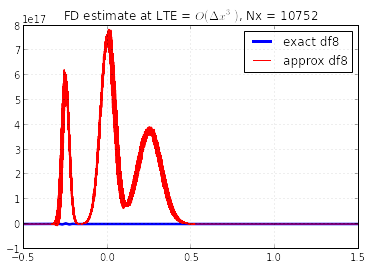

In [52]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df8

Nx = 10752
LTE = 3
dn = 8
x, dx, L = domain(_Nx = Nx) # Nx = 10752 is in convergent zone for FD estimation
L2error, df_approx = FD_derivative_matrix_formulation(_dn = dn, _p = LTE, _Nx = Nx)
df_exact = df8(x)

plt.plot(x,df_exact, label = 'exact df' + str(dn), linewidth = 3)
plt.hold('on')
plt.plot(x,df_approx, label = 'approx df' + str(dn), linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.title('FD estimate at LTE = $O(\Delta x^3)$, Nx = ' + str(Nx))
plt.grid()

In the non-convergent region, not only is the error far larger, the numerical source term contaminates the solution rendering it unrecognizable. A closeup shows the oscillation amplitudes on the fine structure are $|\partial_x^8 f| \sim 10^{15}$ which is on the same order as the values of the derivative itself truly reach. 

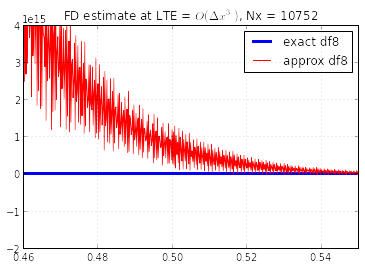

In [53]:
plt.plot(x,df_exact, label = 'exact df' + str(dn), linewidth = 3)
plt.hold('on')
plt.plot(x,df_approx, label = 'approx df' + str(dn), linewidth = 1, color = "red")
plt.hold('off')

plt.legend(loc = 'best')
plt.title('FD estimate at LTE = $O(\Delta x^3)$, Nx = ' + str(Nx))
plt.ylim([-2e15, 4e15])
plt.xlim([.46, .55])
plt.grid()

The larger structure has amplitudes on the order of $|\partial_x^8 f| \sim 10^{17}$ in the numerical solution are many times larger than those in the actual derivative, there is no hope to estimate the true derivative properly.

# Appendix D: Attempts to assuage numerically contaminated solutions

## Can increasing the LTE dampen numerical abberration? ($dn = 8$, $N_x = 10752$ shown)

We try higher order estimations to see if the numerical artifices can be damped and produce a more correct estimation of the exact derivative. If this were to be true, then CS could be pursued at higher order provided we choose a high enough order LTE to allow for convergent solutions. The previous section analyzed $LTE = O(\Delta x^3)$, here, we examine orders $1, 2, 3, 4, 5, 6$. First generate the required FD tables for the scheme application:

In [54]:
cd bin

/home/dsirajud/Work/IPython-notebooks/Convergence of FD formulation of high order CS/pyfiles/bin


In [55]:
import generate_tables_of_finite_difference_schemes_for_a_given_LTE

for LTE in range(1,8):
    generate_tables_of_finite_difference_schemes_for_a_given_LTE.main(LTE = LTE, dn = 8)

In [56]:
cd ..

/home/dsirajud/Work/IPython-notebooks/Convergence of FD formulation of high order CS/pyfiles


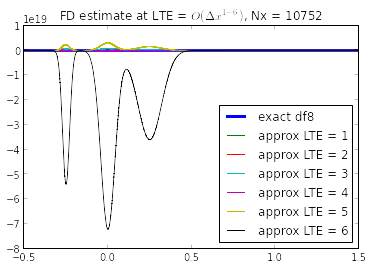

In [57]:
%matplotlib inline
from convergence_routines import FD_derivative_matrix_formulation, domain, df8

Nx = 10752 # non-convergent region
dn = 8

x, dx, L = domain(_Nx = Nx)
df_exact = df8(x)
plt.plot(x,df_exact, label = 'exact df' + str(dn), linewidth = 3)
plt.hold('on')


LTE_min, LTE_max = 1, 6
for LTE in range(LTE_min, LTE_max + 1):

    L2error, df_approx = FD_derivative_matrix_formulation(_dn = dn, _p = LTE, _Nx = Nx)
    plt.plot(x,df_approx, label = 'approx' + ' LTE = ' + str(LTE), linewidth = 1)

    plt.hold('off')
    plt.legend(loc = 'best')
    plt.title('FD estimate at LTE = $O(\Delta x^{%i - %i})$, Nx = ' % (LTE_min, LTE_max) + str(Nx))
    plt.grid()


Unfortunately, the higher the order of the LTE, the worse the approximation is. <b>The erroneous FD estimates cannot be corrected by increasing the LTE in non-convergent regions</b>

Note, it is obvious that reducing the mesh resolution so that it falls in a convergent zone will assuage the problem. Thus, that sort of proofing is not done here as it is redundant (Appendix A).

# Appendix E: simulated FD derivative calculations during advection through an edge (periodic BCs)

We simulate the effect of pushing a density given knowledge of the exact (initial) distribution and plotting $f(t,x) = f_0(x - vt)$ for several snapshots in time when the density encounters the right-hand edge. This is meant to be a proofing by presenting a series of calculations when much of the non-zero and variation of the density is near the edges, that rely on asymmetric FD schemes, and to challenge the schemes to gauge their fidelity.

## $LTE[CS] = O(\Delta x^{14})$ [failing case]

we calculate all the required derivatives at the needed LTEs for CS at this order

In [58]:
cd bin/

/home/dsirajud/Work/IPython-notebooks/Convergence of FD formulation of high order CS/pyfiles/bin


In [59]:
import generate_tables_of_finite_difference_schemes_for_a_given_LTE_on_CS

generate_tables_of_finite_difference_schemes_for_a_given_LTE_on_CS.main(LTE_CS = 14)

In [60]:
cd ..

/home/dsirajud/Work/IPython-notebooks/Convergence of FD formulation of high order CS/pyfiles


advected by dx = 0, dn = 1, LTE = 12
See plots of density and corresponding convergence plot (at bottom)
a central differencing scheme exists: LTE between 12 and 13 expected if density far from edges

order calculations at each refinement step:
Nx24        error = 90.8374       ----
Nx48        error = 6.42762       order = 3.82093
Nx96        error = 0.158194       order = 5.34452
Nx192        error = 0.000677468       order = 7.86733
Nx384        error = 4.26498e-07       order = 10.6334
Nx768        error = 5.6577e-09       order = 6.23618
Nx1536        error = 2.65493e-09       order = 1.09154


advected by dx = 0.02, dn = 1, LTE = 12
See plots of density and corresponding convergence plot (at bottom)
a central differencing scheme exists: LTE between 12 and 13 expected if density far from edges

order calculations at each refinement step:
Nx24        error = 39.0577       ----
Nx48        error = 31.2885       order = 0.319974
Nx96        error = 0.200199       order = 7.28806
Nx19

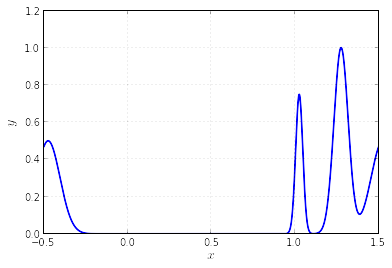

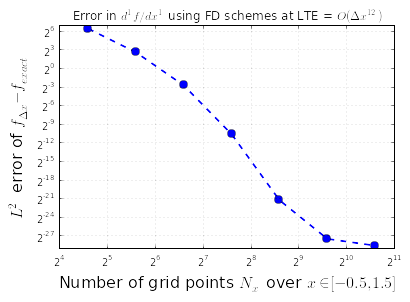

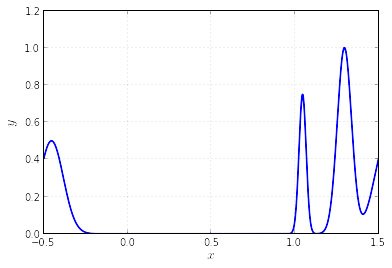

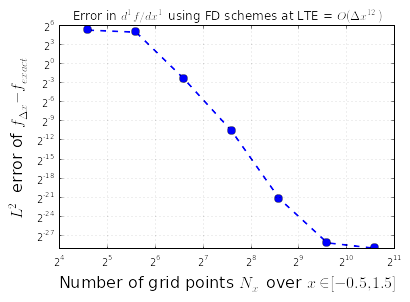

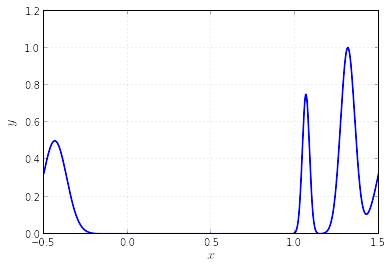

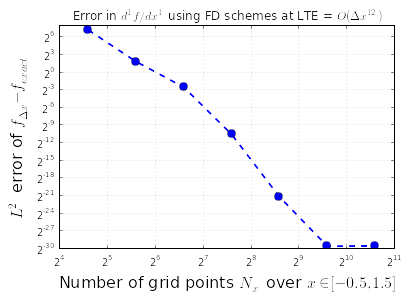

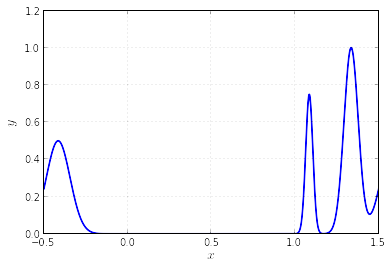

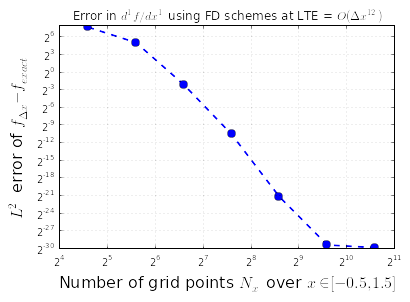

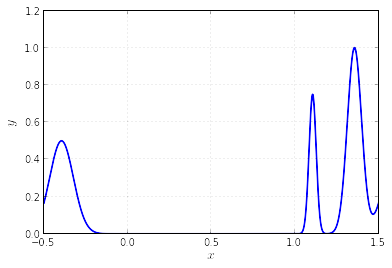

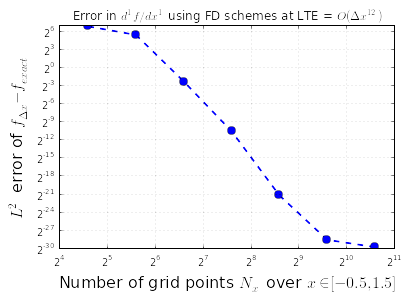

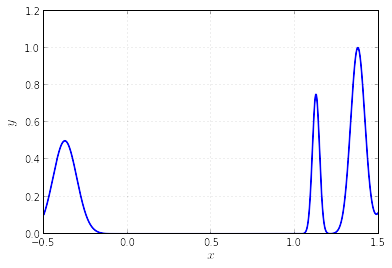

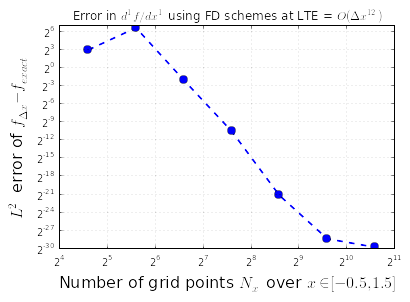

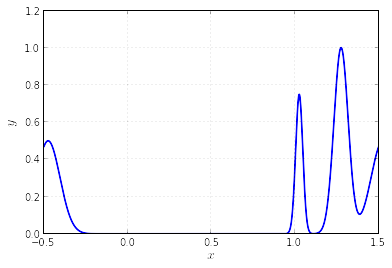

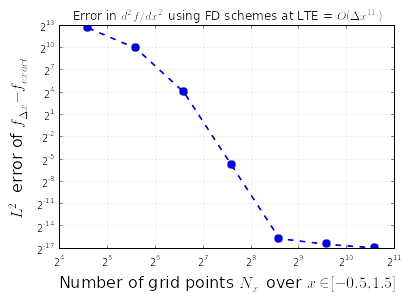

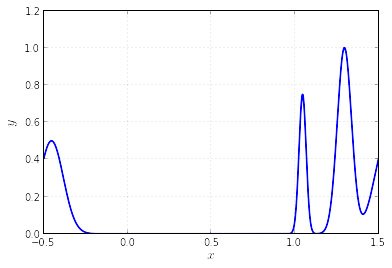

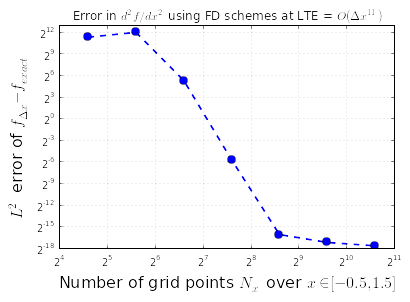

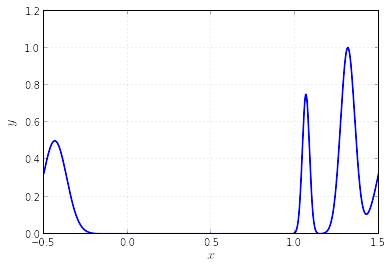

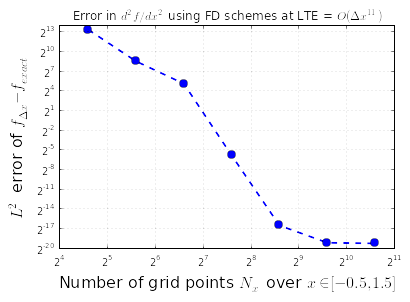

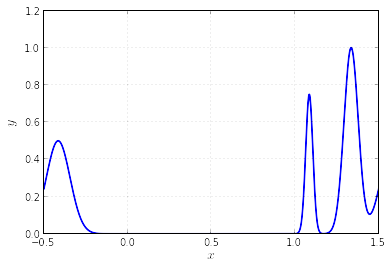

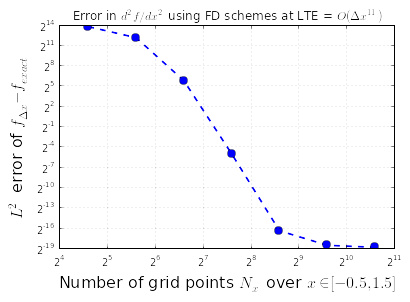

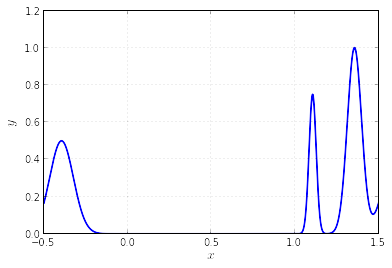

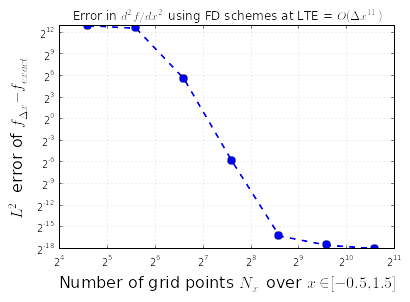

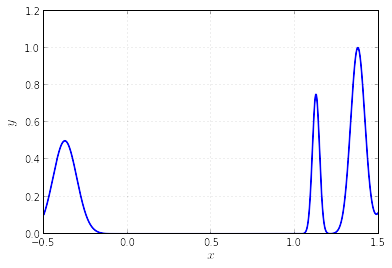

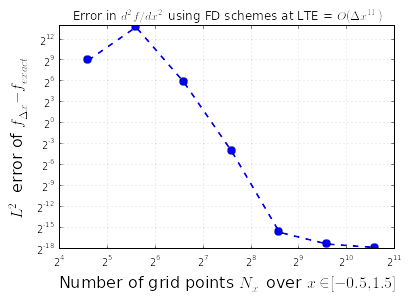

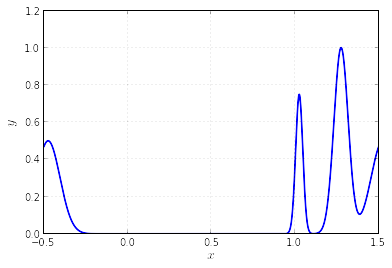

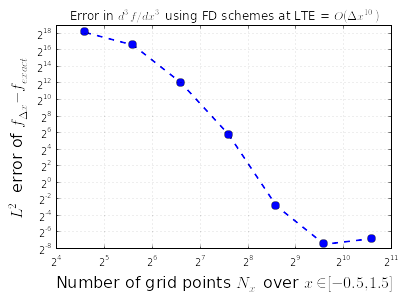

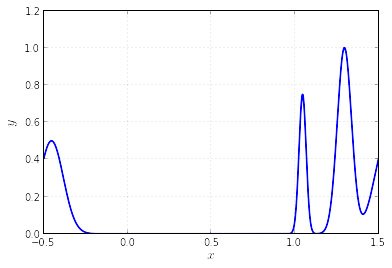

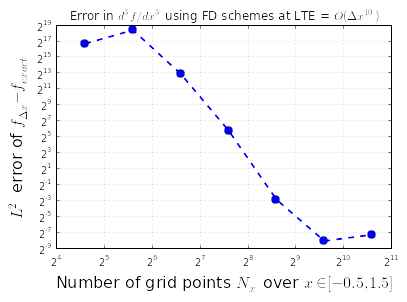

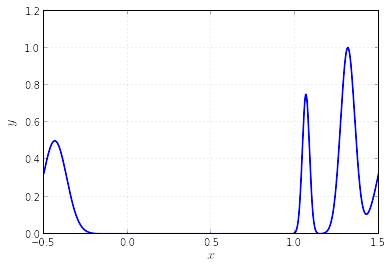

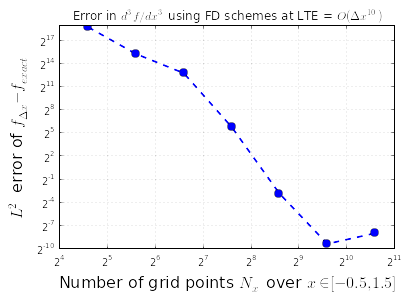

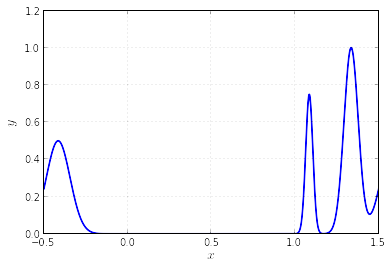

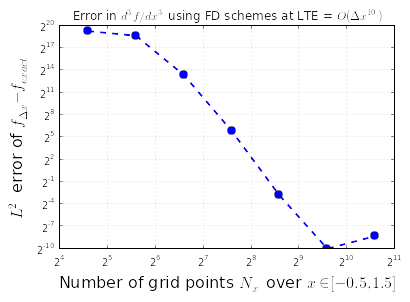

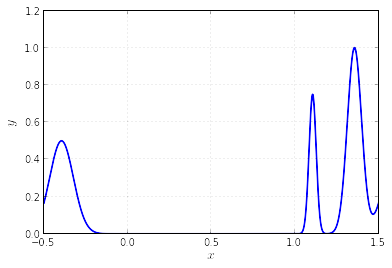

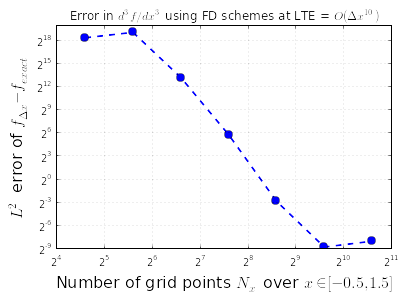

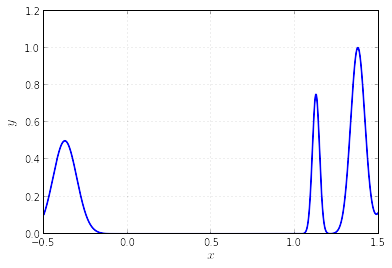

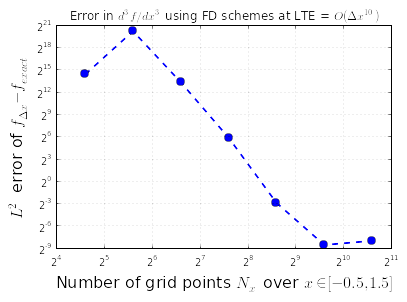

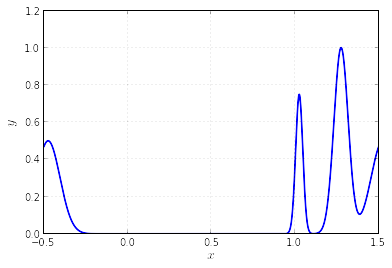

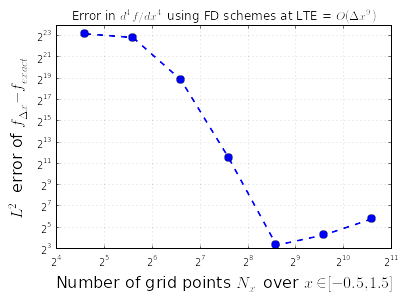

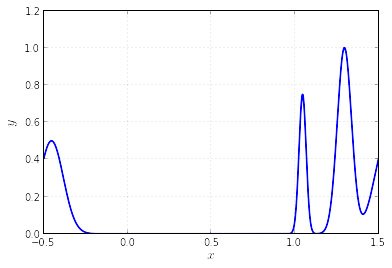

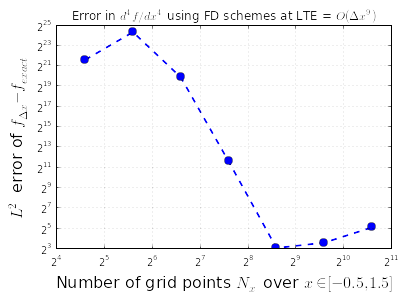

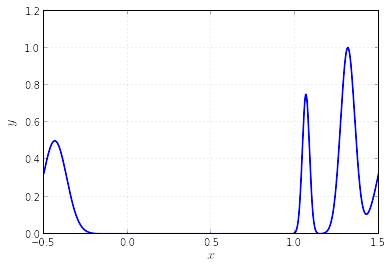

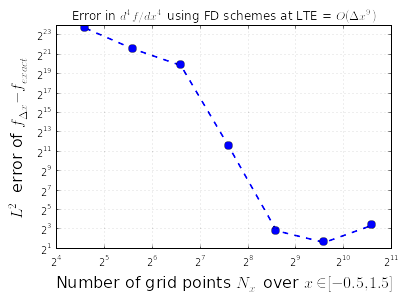

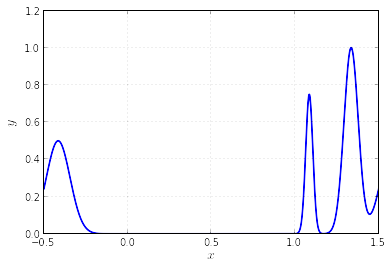

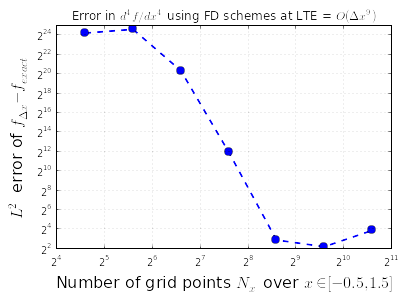

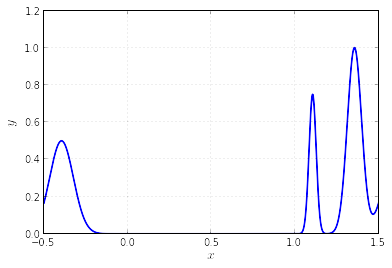

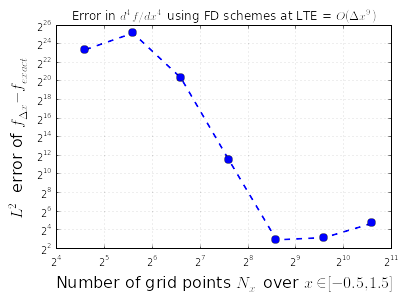

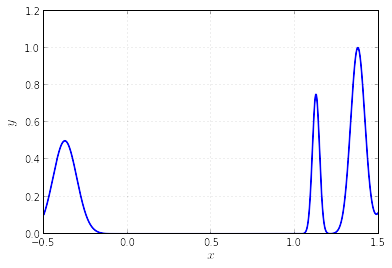

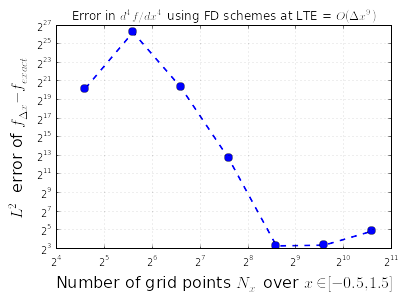

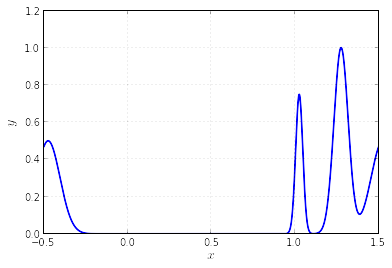

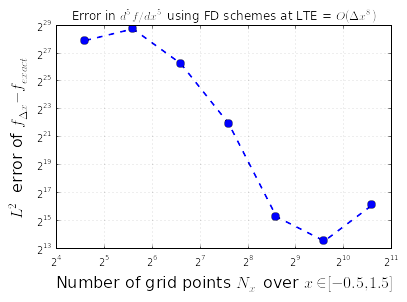

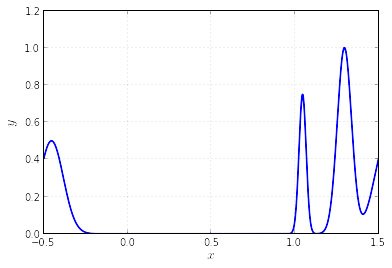

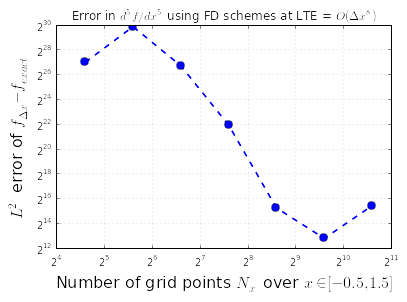

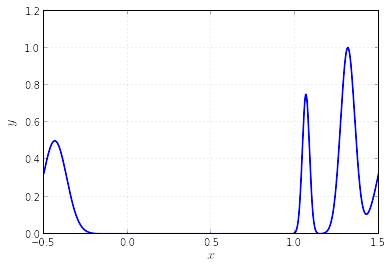

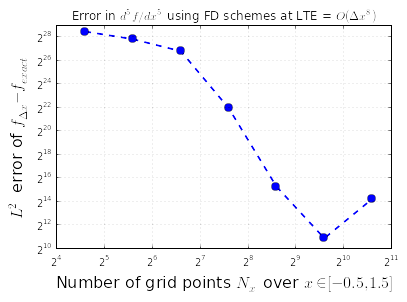

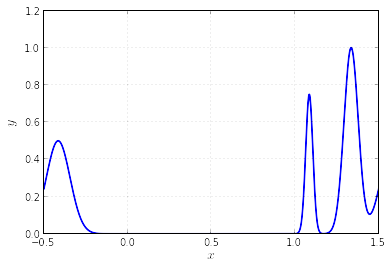

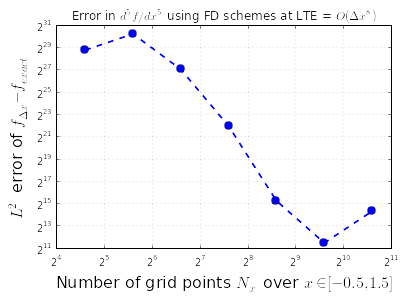

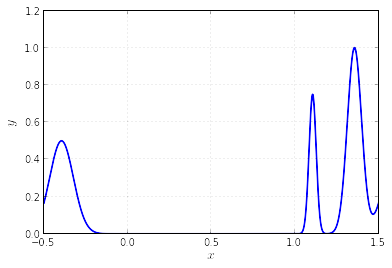

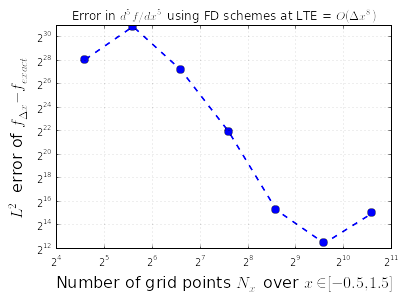

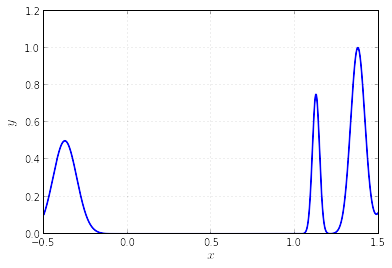

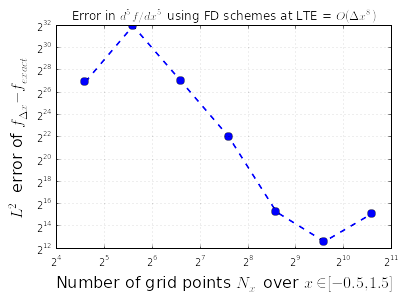

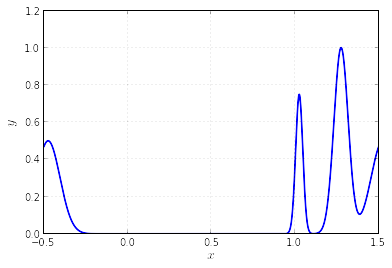

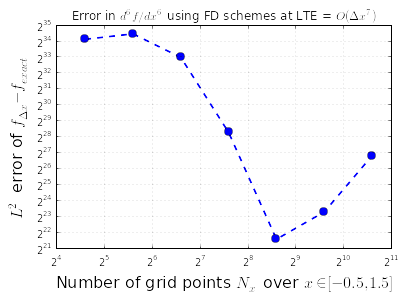

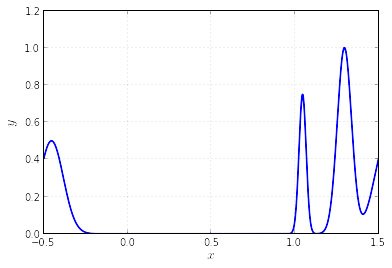

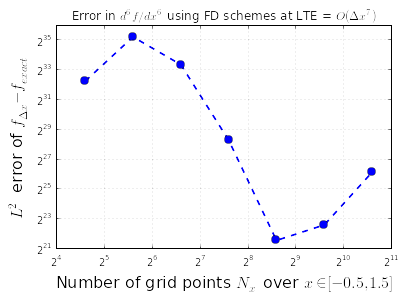

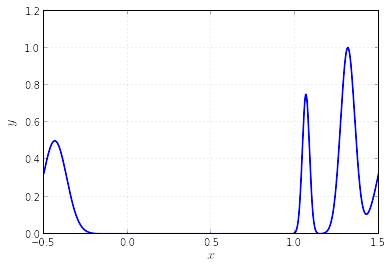

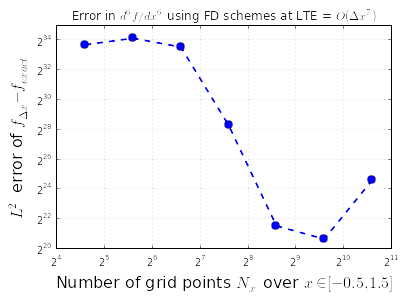

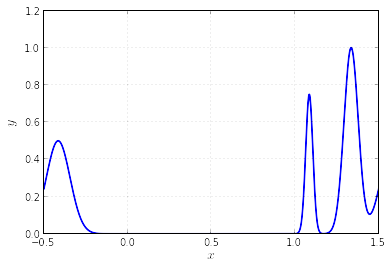

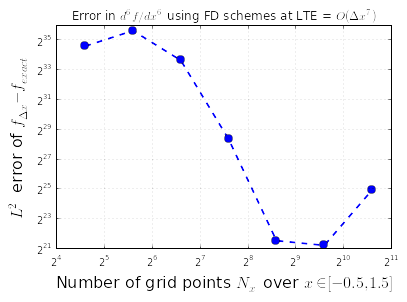

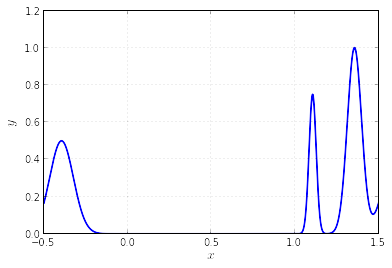

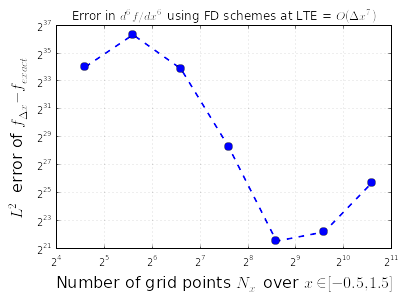

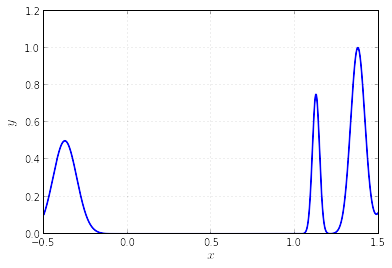

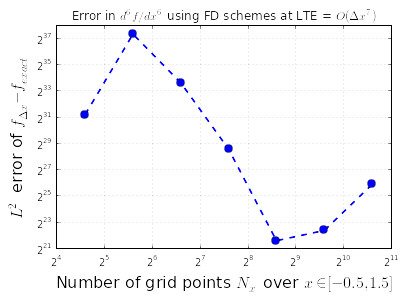

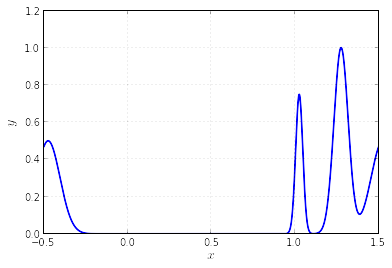

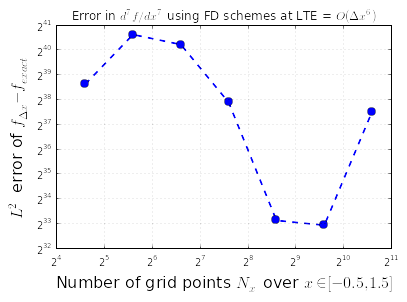

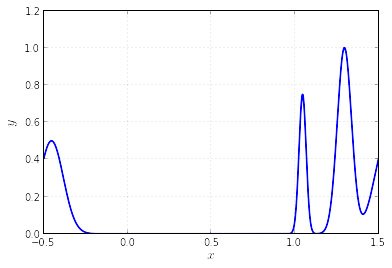

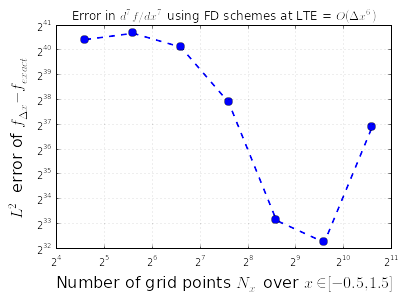

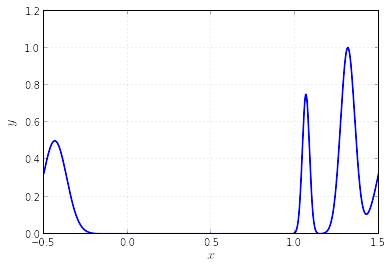

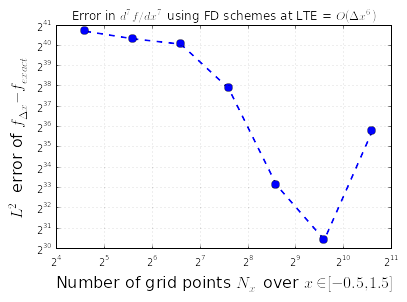

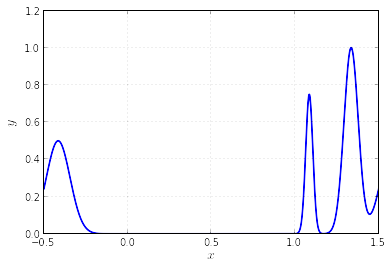

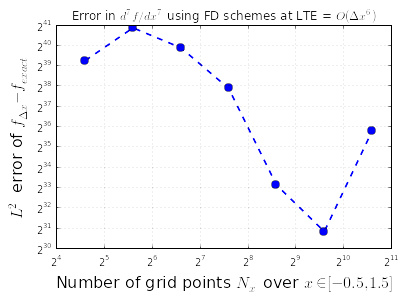

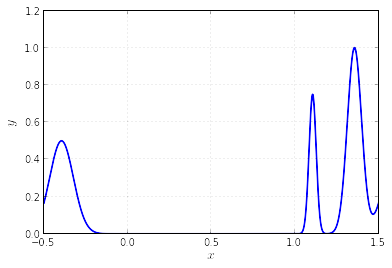

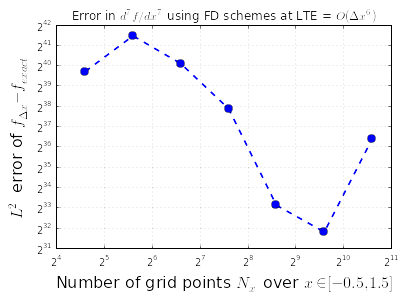

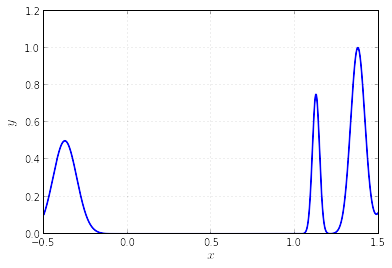

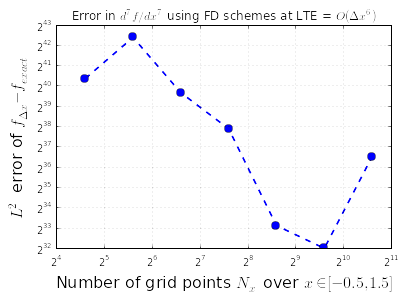

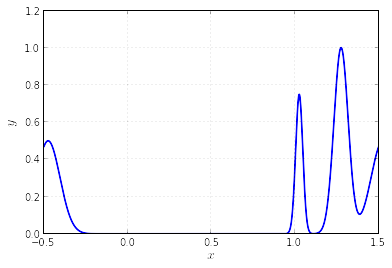

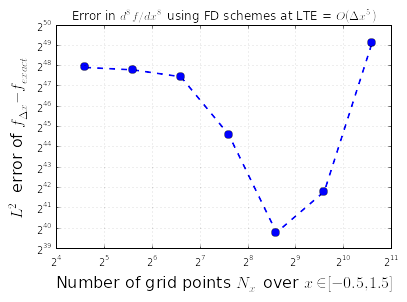

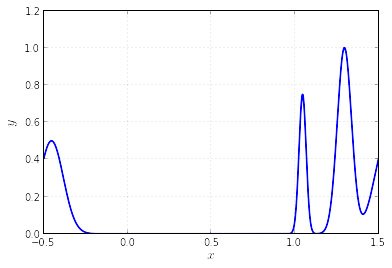

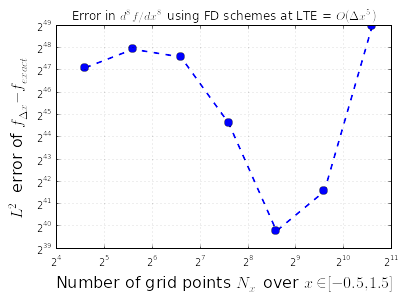

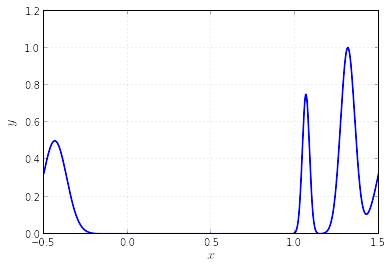

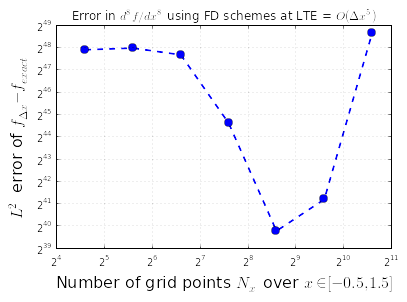

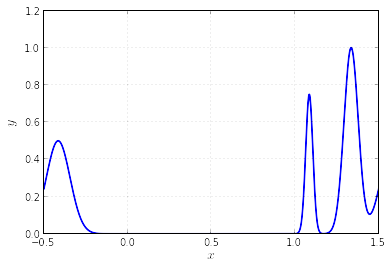

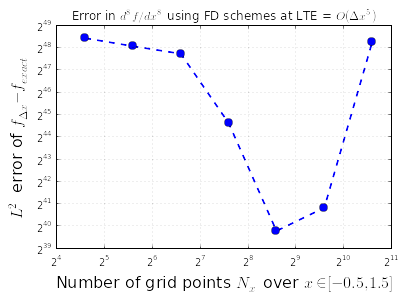

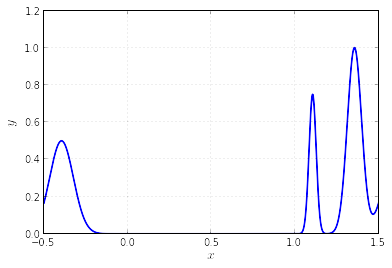

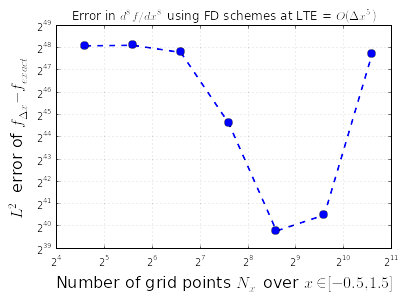

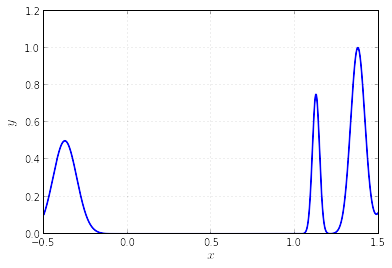

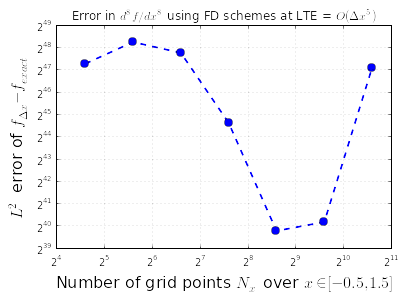

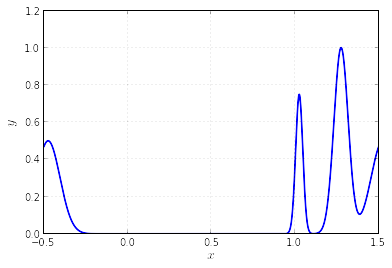

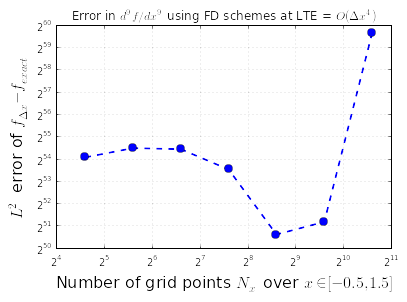

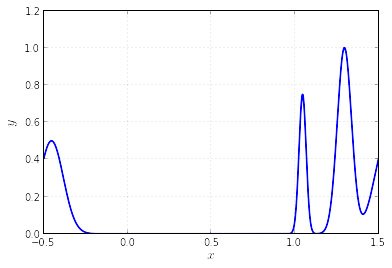

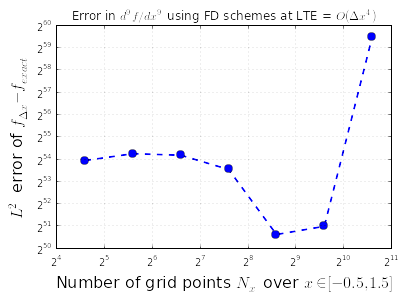

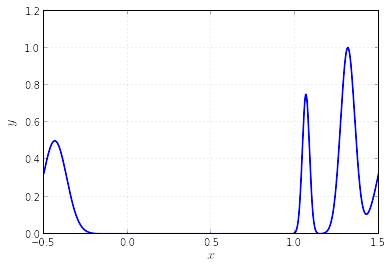

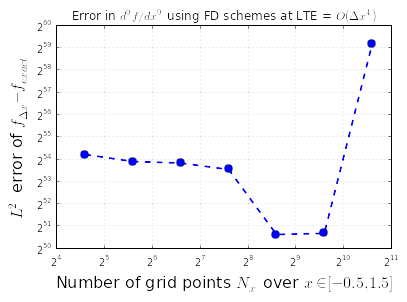

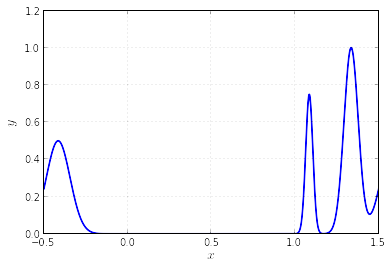

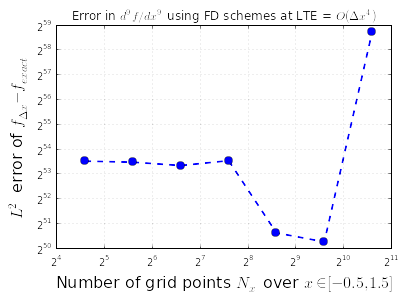

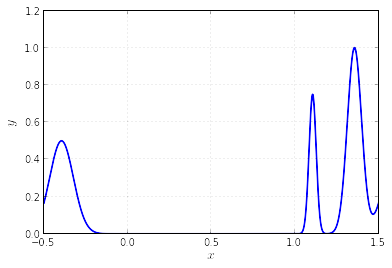

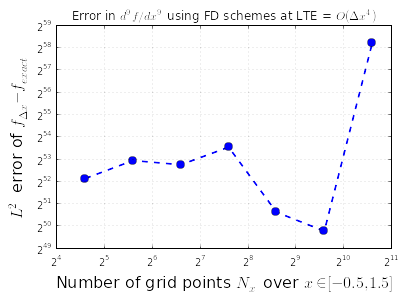

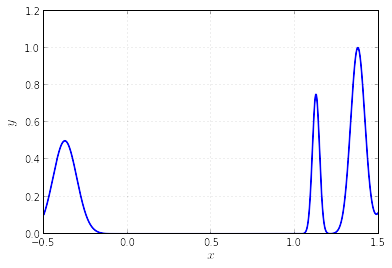

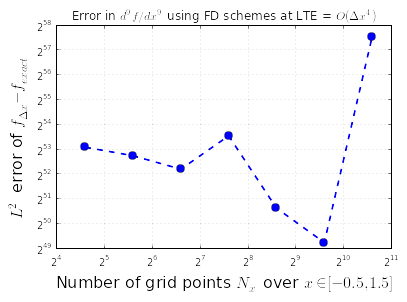

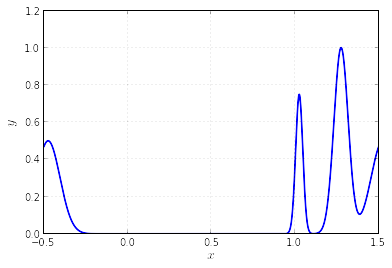

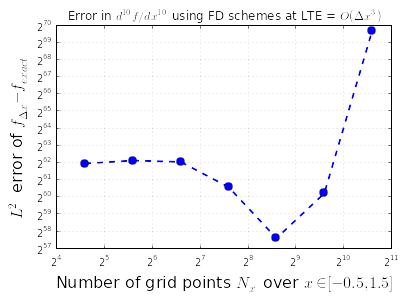

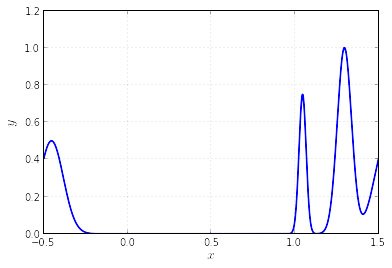

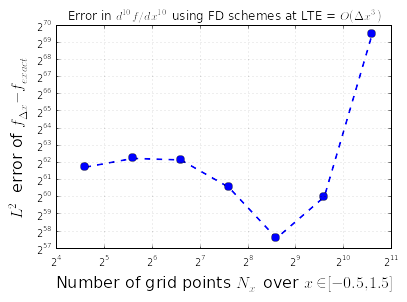

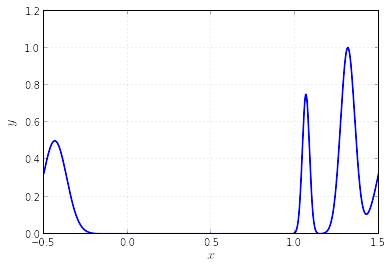

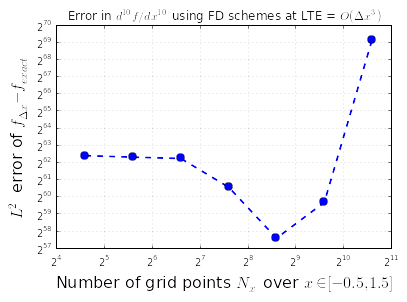

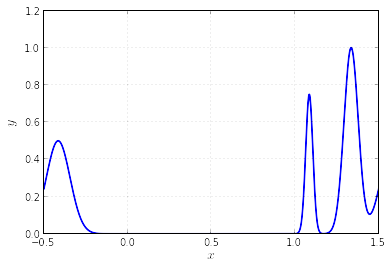

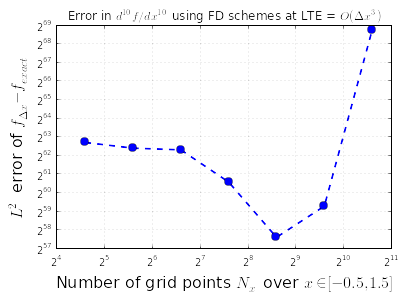

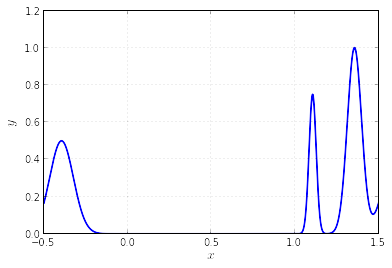

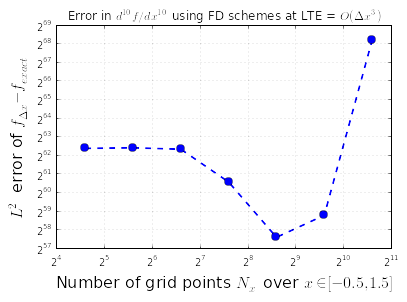

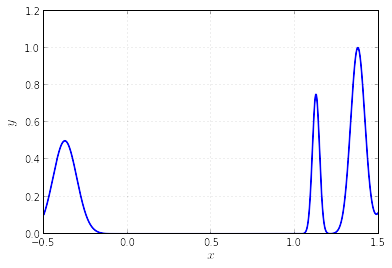

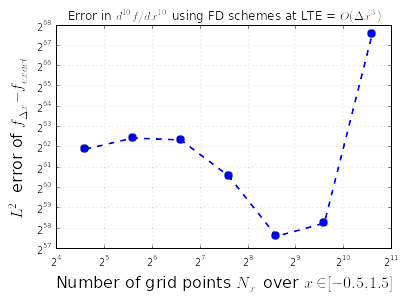

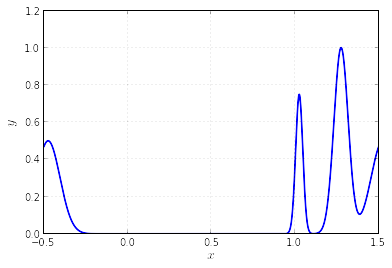

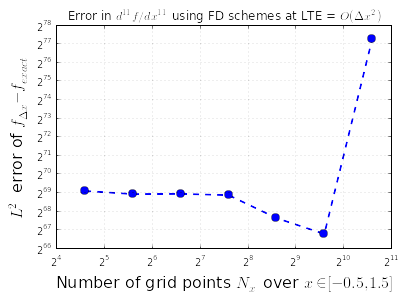

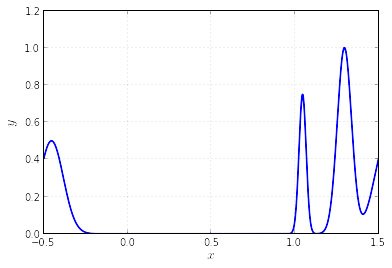

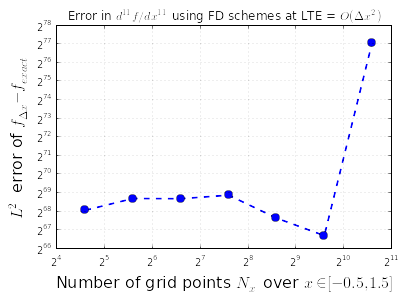

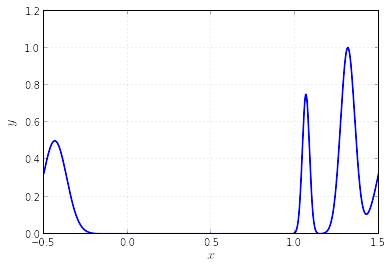

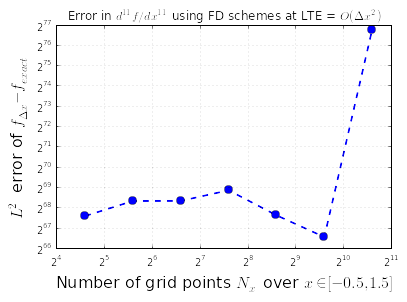

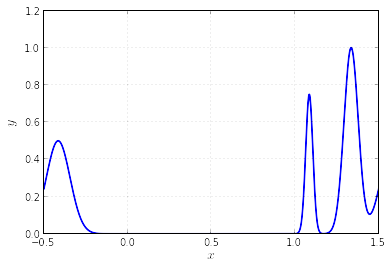

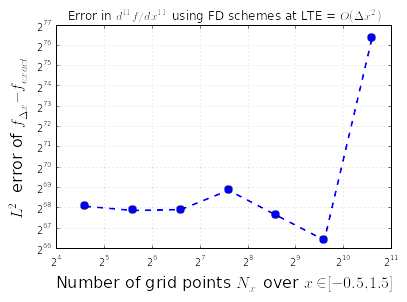

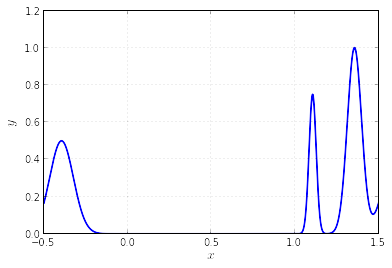

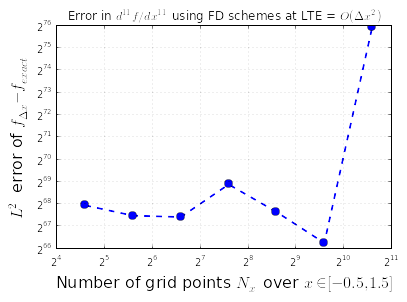

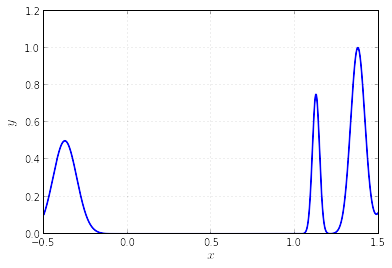

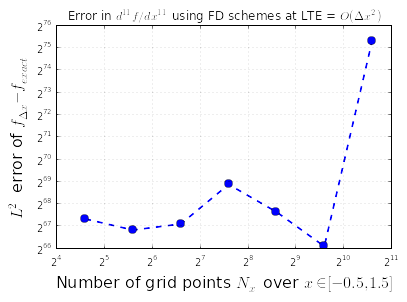

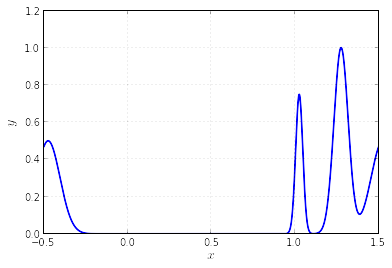

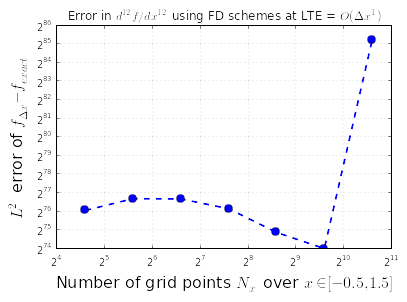

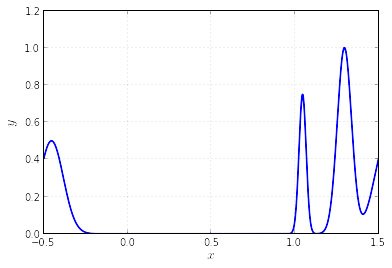

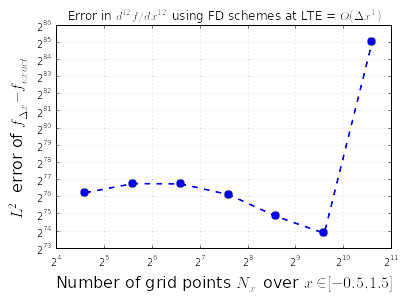

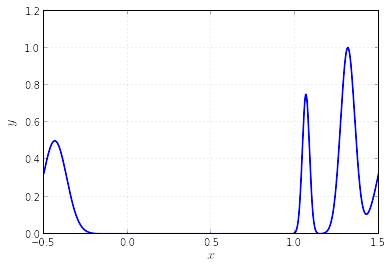

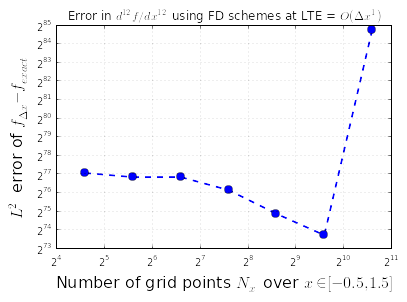

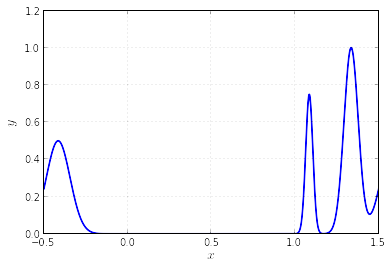

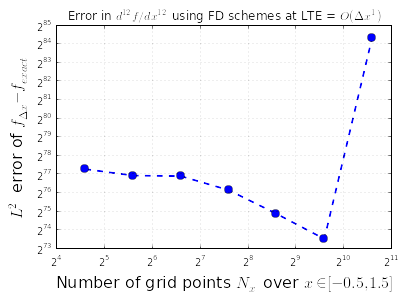

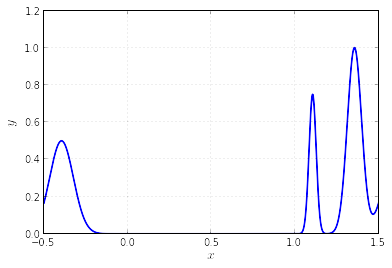

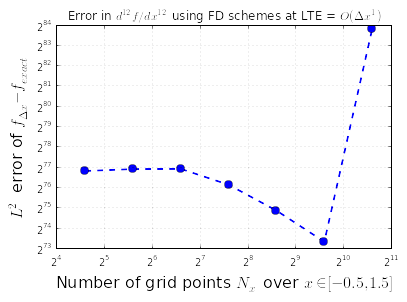

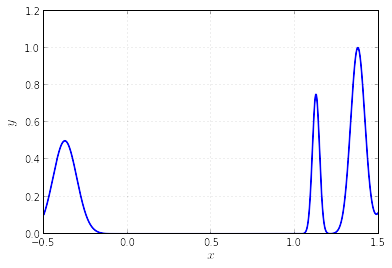

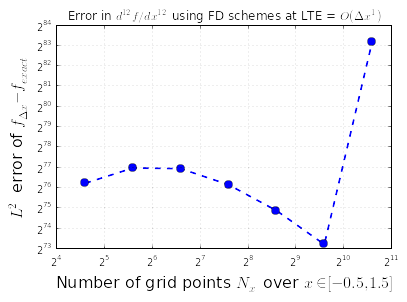

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
from convergence_routines import convergence_routine_nonperiodic

LTE_CS = 14
N = LTE_CS - 1
Dx = 0.02 # push per timestep

for dn in range(1,N):
    # consider 6 snapshots in the advection through the edge, push by i*Dx each timestep
    for i in range(6): 
        print "advected by dx = %g, dn = %d, LTE = %d" % (i*Dx, dn, N - dn)
    
        f = convergence_routines.function_edge(x, x_a = -1.025 - i*Dx, x_b = -1.275 - i*Dx, x_c = -1.525 - i*Dx, x_d = 0.475 - i*Dx)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(x,f,'-b', linewidth = 2)
        ax.grid()
        plt.xlabel('$x$', fontsize = 14)
        plt.ylabel('$y$', fontsize = 14)
    
        print "See plots of density and corresponding convergence plot (at bottom)"
        dummy_out1, dummy_out2 = convergence_routine_nonperiodic(NumGrids = 7, Nx = 24, LTE = N - dn, dn = dn, plots = 'yes', edge = 'yes',
                                                             x_a = -1.025 - i*Dx, x_b = -1.275 - i*Dx, x_c = -1.525 - i*Dx, x_d = 0.475 - i*Dx)